# Análisis de Crímenes 2024

Este notebook contiene el análisis exploratorio de datos sobre crímenes reportados en 2024.

## Importación de Librerías

Importamos las bibliotecas necesarias para el análisis de datos:

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


sns.set_theme(style='whitegrid')

df = pd.read_csv('lib/Crimes_-_2024_20251122.csv', low_memory=False)


print("Primeras 5 filas del dataset:")
display(df.head())
print('Data shape (filas, columnas)',df.shape)

print("Data types", df.dtypes)

columns = df.columns.tolist()
print("columns", columns)

Primeras 5 filas del dataset:


ID Case Number                    Date  \
0  13709672    JJ101940  12/31/2024 11:58:00 PM   
1  13707925    JJ100089  12/31/2024 11:56:00 PM   
2  13708038    JJ100035  12/31/2024 11:55:00 PM   
3  13709164    JJ101392  12/31/2024 11:53:00 PM   
4  13707823    JJ100020  12/31/2024 11:50:00 PM   

                                 Block  IUCR       Primary Type  \
0                      014XX E 68TH ST  1310    CRIMINAL DAMAGE   
1  047XX S DR MARTIN LUTHER KING JR DR  1365  CRIMINAL TRESPASS   
2                   077XX S CICERO AVE  0498            BATTERY   
3                066XX S GREENWOOD AVE  1320    CRIMINAL DAMAGE   
4                   012XX N MENARD AVE  0460            BATTERY   

                                         Description Location Description  \
0                                        TO PROPERTY            APARTMENT   
1                                       TO RESIDENCE            APARTMENT   
2  AGG. DOMESTIC BATTERY - HANDS, FISTS, FEET, SE...        HOTEL / MOTEL   
3                                         TO VEHICLE               STREET   
4                                             SIMPLE             SIDEWALK   

   Arrest  Domestic  ...  Ward  Community Area  FBI Code  X Coordinate  \
0   False     False  ...     5              43        14     1186817.0   
1    True      True  ...     3              38        26     1179661.0   
2   False      True  ...    18              70       04B     1145740.0   
3   False     False  ...    20              42        14     1184362.0   
4   False     False  ...    29              25       08B     1137458.0   

  Y Coordinate  Year              Updated On   Latitude  Longitude  \
0    1860189.0  2024  11/02/2025 03:41:09 PM  41.771470 -87.590742   
1    1873623.0  2024  05/17/2025 03:40:52 PM  41.808501 -87.616563   
2    1853048.0  2024  11/02/2025 03:41:09 PM  41.752749 -87.741498   
3    1861188.0  2024  11/02/2025 03:41:09 PM  41.774269 -87.599710   
4    1907694.0  2024  05/17/2025 03:40:52 PM  41.902858 -87.770537   

                             Location  
0   POINT (-87.59074212 41.771470188)  
1  POINT (-87.616562762 41.808500903)  
2  POINT (-87.741497836 41.752748627)  
3  POINT (-87.599709962 41.774269351)  
4  POINT (-87.770536741 41.902858242)  

[5 rows x 22 columns]

Data shape (filas, columnas) (258829, 22)
Data types ID                        int64
Case Number              object
Date                     object
Block                    object
IUCR                     object
Primary Type             object
Description              object
Location Description     object
Arrest                     bool
Domestic                   bool
Beat                      int64
District                  int64
Ward                      int64
Community Area            int64
FBI Code                 object
X Coordinate            float64
Y Coordinate            float64
Year                      int64
Updated On               object
Latitude                float64
Longitude               float64
Location                 object
dtype: object
columns ['ID', 'Case Number', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description', 'Location Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'Community Area', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Year',

## Análisis de Tipos de Datos

A continuación se muestra una tabla detallada de los tipos de datos para cada columna del dataset:

In [3]:
# Tabla simple: id (nombre de la columna) y tipo_de_dato (dtype)
tipos_tabla = pd.DataFrame({
    'id': df.columns.tolist(),
    'tipo_de_dato': [str(df[col].dtype) for col in df.columns]
})

print("\nTabla con id y tipo de dato:")
display(tipos_tabla)


Tabla con id y tipo de dato:


id tipo_de_dato
0                     ID        int64
1            Case Number       object
2                   Date       object
3                  Block       object
4                   IUCR       object
5           Primary Type       object
6            Description       object
7   Location Description       object
8                 Arrest         bool
9               Domestic         bool
10                  Beat        int64
11              District        int64
12                  Ward        int64
13        Community Area        int64
14              FBI Code       object
15          X Coordinate      float64
16          Y Coordinate      float64
17                  Year        int64
18            Updated On       object
19              Latitude      float64
20             Longitude      float64
21              Location       object

# Interpretación de variables

| Nombre de columna | Descripción | Tipo de dato (Database) | Tipo de variable (Clasificación) |
|-------------------|-------------|-------------------------|------------------------------|
| ID | Identificador único del registro | Number | Categórica |
| Case Number | El número RD(Record Division Number) del departamento de policía de Chicago | Text | Categórica |
| Date | Fecha en la que ocurrió el incidente. A veces es estimada | Timestamp | Fecha |
| Block | La dirección parcialmente redactada donde ocurrió el incidente, colocándola en la misma cuadra que la dirección real. | Text | Categórica nominal |
| IUCR | El código de Reporte Uniforme de Delitos de Illinois. Esto está directamente vinculado con Primary Type y Description. Consulte la lista de códigos IUCR en https://data.cityofchicago.org/d/c7ck-438e. | Text | Categórica nominal |
| Primary Type | La descripción primaria del código IUCR | Text | Categórica nominal |
| Description | La descripción secundaria del código IUCR, una subcategoría de la descripción primaria. | Text | Categórica nominal |
| Location Description | Descripción de la ubicación en donde ocurrió el incidente | Text | Categórica nominal |
| Arrest | Indica si se hizo un arresto. | Checkbox | Categórica nominal |
| Domestic | Indica si el incidente estuvo relacionado con violencia doméstica según lo definido por la Ley de Violencia Doméstica de Illinois. | Checkbox | Categórica nominal |
| Beat | Indica el sector donde ocurrió el incidente. Un sector es la zona geográfica más pequeña de la policía: cada sector tiene un coche de policía dedicado. De tres a cinco sectores conforman un distrito policial y tres distritos forman un distrito de policía. El Departamento de Policía de Chicago tiene 22 distritos policiales. Vea los sectores en https://data.cityofchicago.org/d/aerh-rz74. | Text | Categórica nominal |
| District | Indica el distrito policial donde ocurrió el incidente. Consulte los distritos en https://data.cityofchicago.org/d/fthy-xz3r. | Text | Categórica nominal |
| Ward | El distrito (distrito del Ayuntamiento) donde ocurrió el incidente. Vea los distritos en https://data.cityofchicago.org/d/sp34-6z76. | Text | Categórica nominal |
| Community Area | Indica el área comunitaria donde ocurrió el incidente. Chicago tiene 77 áreas comunitarias. Vea las áreas comunitarias en https://data.cityofchicago.org/d/cauq-8yn6. | Text | Categórica nominal |
| FBI Code | Indica la clasificación del delito según lo establecido en el Sistema Nacional de Informes Basado en Incidentes (NIBRS) del FBI. Consulte el listado de estas clasificaciones del Departamento de Policía de Chicago en https://gis.chicagopolice.org/pages/crime_details. | Text | Categórica nominal |
| X Coordinate | La coordenada X del lugar donde ocurrió el incidente en la proyección State Plane Illinois East NAD 1983. Esta ubicación se ha desplazado del lugar real por motivos de redacción parcial, pero se encuentra en la misma manzana. | Number | Categórica/Numérica |
| Y Coordinate | La coordenada Y del lugar donde ocurrió el incidente en la proyección State Plane Illinois East NAD 1983. Esta ubicación se ha desplazado del lugar real por motivos de redacción parcial, pero se encuentra en la misma manzana. | Number | Categórica/Numérica |
| Year | Año en el que ocurrió el incidente. | Number | Numérica discreta |
| Updated On | Día y hora en los que el registro se actualizó por última vez. | Timestamp | Fecha |
| Latitude | La latitud del lugar donde ocurrió el incidente. Esta ubicación se ha desplazado respecto a la ubicación real para una redacción parcial, pero se encuentra en la misma manzana. | Number | Categórica/Numérica |
| Longitude | La longitud del lugar donde ocurrió el incidente. Esta ubicación se ha desplazado respecto a la ubicación real para una redacción parcial, pero se encuentra en la misma manzana. | Number | Categórica/Numérica |
| Location | La ubicación donde ocurrió el incidente en un formato que permite la creación de mapas y otras operaciones geográficas en este portal de datos. Esta ubicación está desplazada respecto a la ubicación real para una redacción parcial, pero se encuentra en la misma manzana. | Point | Categórica |

Prácticamente, todas las variables son categóricas, sin embargo podrían considerarse ocasionalmente numéricas aquellas de ubicación por coordenadas y de fechas. Pueden agruparse las variables por el tipo de información que brindan:
- Identificación: ID, Case Number
- Fechas: Date, Year, Updated On
- Ubicación: Latitude, Longitude, X Coordinate, Y Coordinate, Beat, Community Area, District, Ward, Block, Location
- Clasificación: Primary Type, Description, Location Description, IUCR, FBI Code
- Situación legal: Arrest (True/False), Domestic (True/False)


### Crímenes agrupados por tiempo/fechas

In [4]:
df['Date_raw'] = pd.to_datetime(df['Date'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')

df['Month'] = df['Date_raw'].dt.month

df['Day'] = df['Date_raw'].dt.dayofyear

df['Hour'] = df['Date_raw'].dt.hour

df['WeekDay'] = df['Date_raw'].dt.day_name()

print(f"Se verifica si quedó alguna fila sin parsear: {df['Date_raw'].isna().sum()}")

Se verifica si quedó alguna fila sin parsear: 0


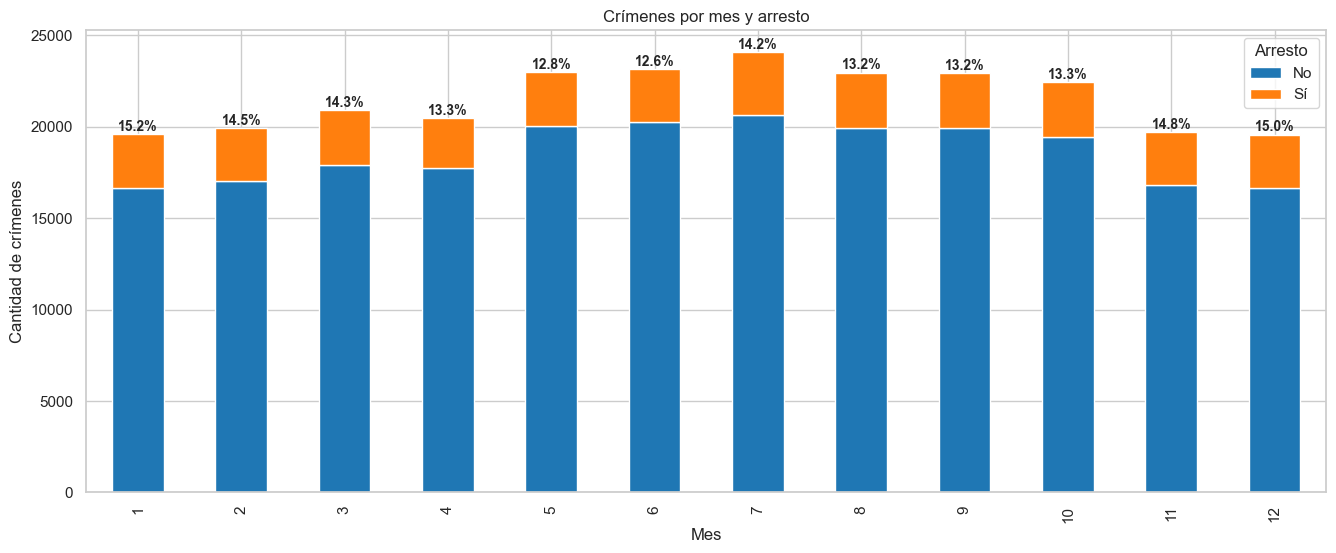

In [5]:
# Agrupar por mes y arresto
crimenes_mes_arresto = df.groupby(['Month', 'Arrest']).size().unstack(fill_value=0)
totales = crimenes_mes_arresto[False] + crimenes_mes_arresto[True]
porcentajes = 100 * crimenes_mes_arresto[True] / totales.replace(0, np.nan)

# Graficar barras apiladas
ax = crimenes_mes_arresto.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 6),
    color=['#1f77b4', '#ff7f0e']
)

for idx, pct in enumerate(porcentajes):
    if not np.isnan(pct):
        ax.text(
            idx, totales.iloc[idx] + 20,  # posición encima de la barra
            f'{pct:.1f}%', 
            ha='center', va='bottom', fontsize=10, fontweight='bold'
        )

plt.title('Crímenes por mes y arresto')
plt.xlabel('Mes')
plt.ylabel('Cantidad de crímenes')
plt.legend(title='Arresto', labels=['No', 'Sí'])
plt.show()

Se puede observar un aumento de los crímenes hacia los mese más calurosos del año o, visto al revés, un descenso hacia los meses más fríos.

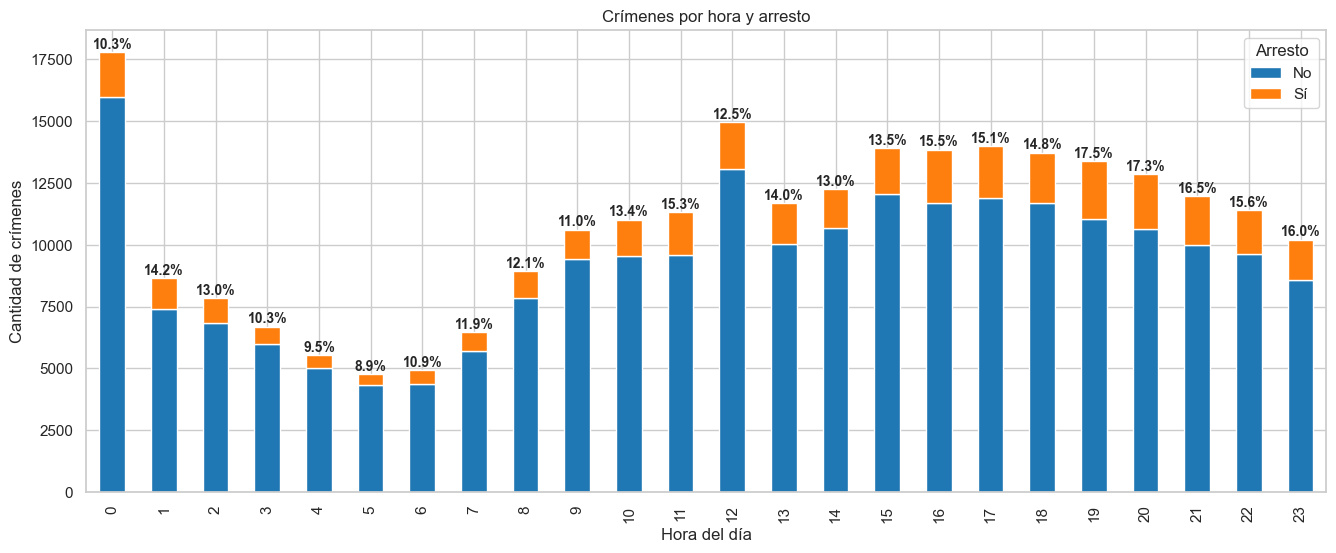

In [6]:
crimenes_hora_arresto = df.groupby(['Hour', 'Arrest']).size().unstack(fill_value=0)
totales = crimenes_hora_arresto[False] + crimenes_hora_arresto[True]
porcentajes = 100 * crimenes_hora_arresto[True] / totales.replace(0, np.nan)

ax = crimenes_hora_arresto.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 6),
    color=['#1f77b4', '#ff7f0e']
)

for idx, pct in enumerate(porcentajes):
    if not np.isnan(pct):
        ax.text(
            idx, totales.iloc[idx] + 20,  # posición encima de la barra
            f'{pct:.1f}%', 
            ha='center', va='bottom', fontsize=10, fontweight='bold'
        )

plt.title('Crímenes por hora y arresto')
plt.xlabel('Hora del día')
plt.ylabel('Cantidad de crímenes')
plt.legend(title='Arresto', labels=['No', 'Sí'])
plt.show()

Se puede observar casi una curva suave a medida que se avanza en horas, salvo por dos picos a las 00hs y 12 hs (En 24hs), probablemente debido cómo se registran los delitos con horarios no conocidos con precisión según el turno.
Descartando estos picos, se ve una disminución hacia las 5hs y 6hs (madrugada) y un aumento en el rango de 15hs a 18hs.

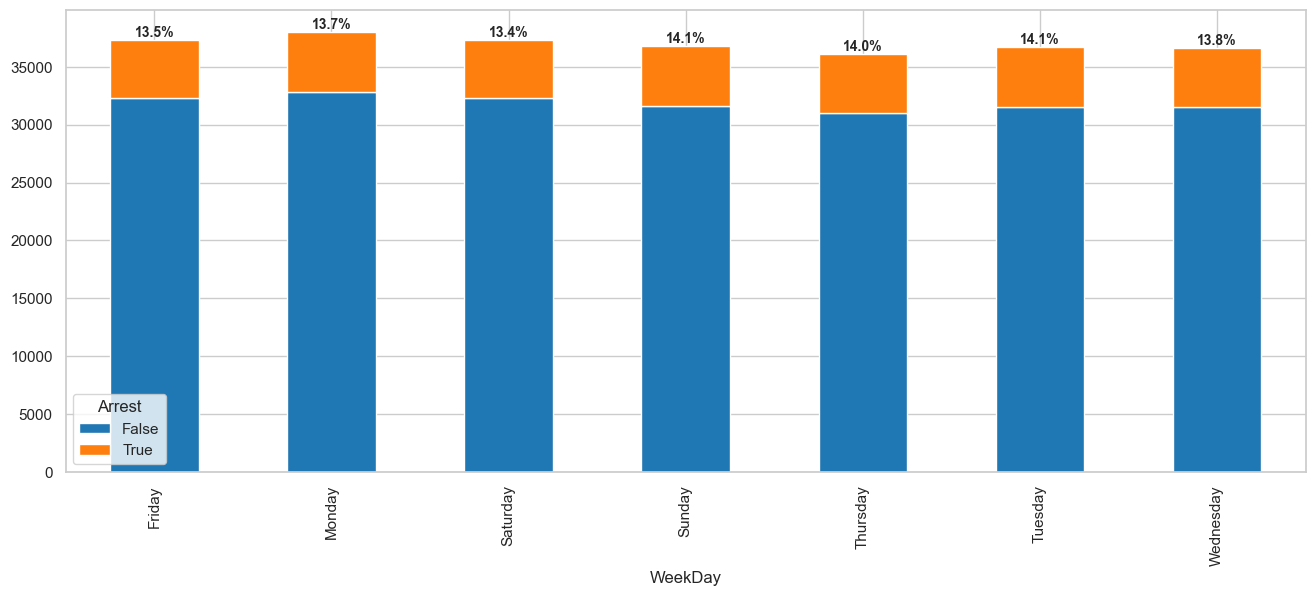

In [7]:
crimenes_dia_arresto = df.groupby(['WeekDay', 'Arrest']).size().unstack(fill_value=False)
totales = crimenes_dia_arresto[False] + crimenes_dia_arresto[True]
porcentajes = 100 * crimenes_dia_arresto[True] / totales.replace(0, np.nan)

ax = crimenes_dia_arresto.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 6),
    color=['#1f77b4', '#ff7f0e']
)

for idx, pct in enumerate(porcentajes):
    if not np.isnan(pct):
        ax.text(
            idx, totales.iloc[idx] + 20,
            f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold'
        )

No se ve una diferencia notable entre cada día de la semana.

In [8]:
import calendar
import locale

# Configurar locale para nombres de meses en español
locale.setlocale(locale.LC_ALL, 'es_ES')
nombres_meses = {1:'Enero', 2:'Febrero', 3:'Marzo', 4:'Abril', 
                5:'Mayo', 6:'Junio', 7:'Julio', 8:'Agosto',
                9:'Septiembre', 10:'Octubre', 11:'Noviembre', 12:'Diciembre'}

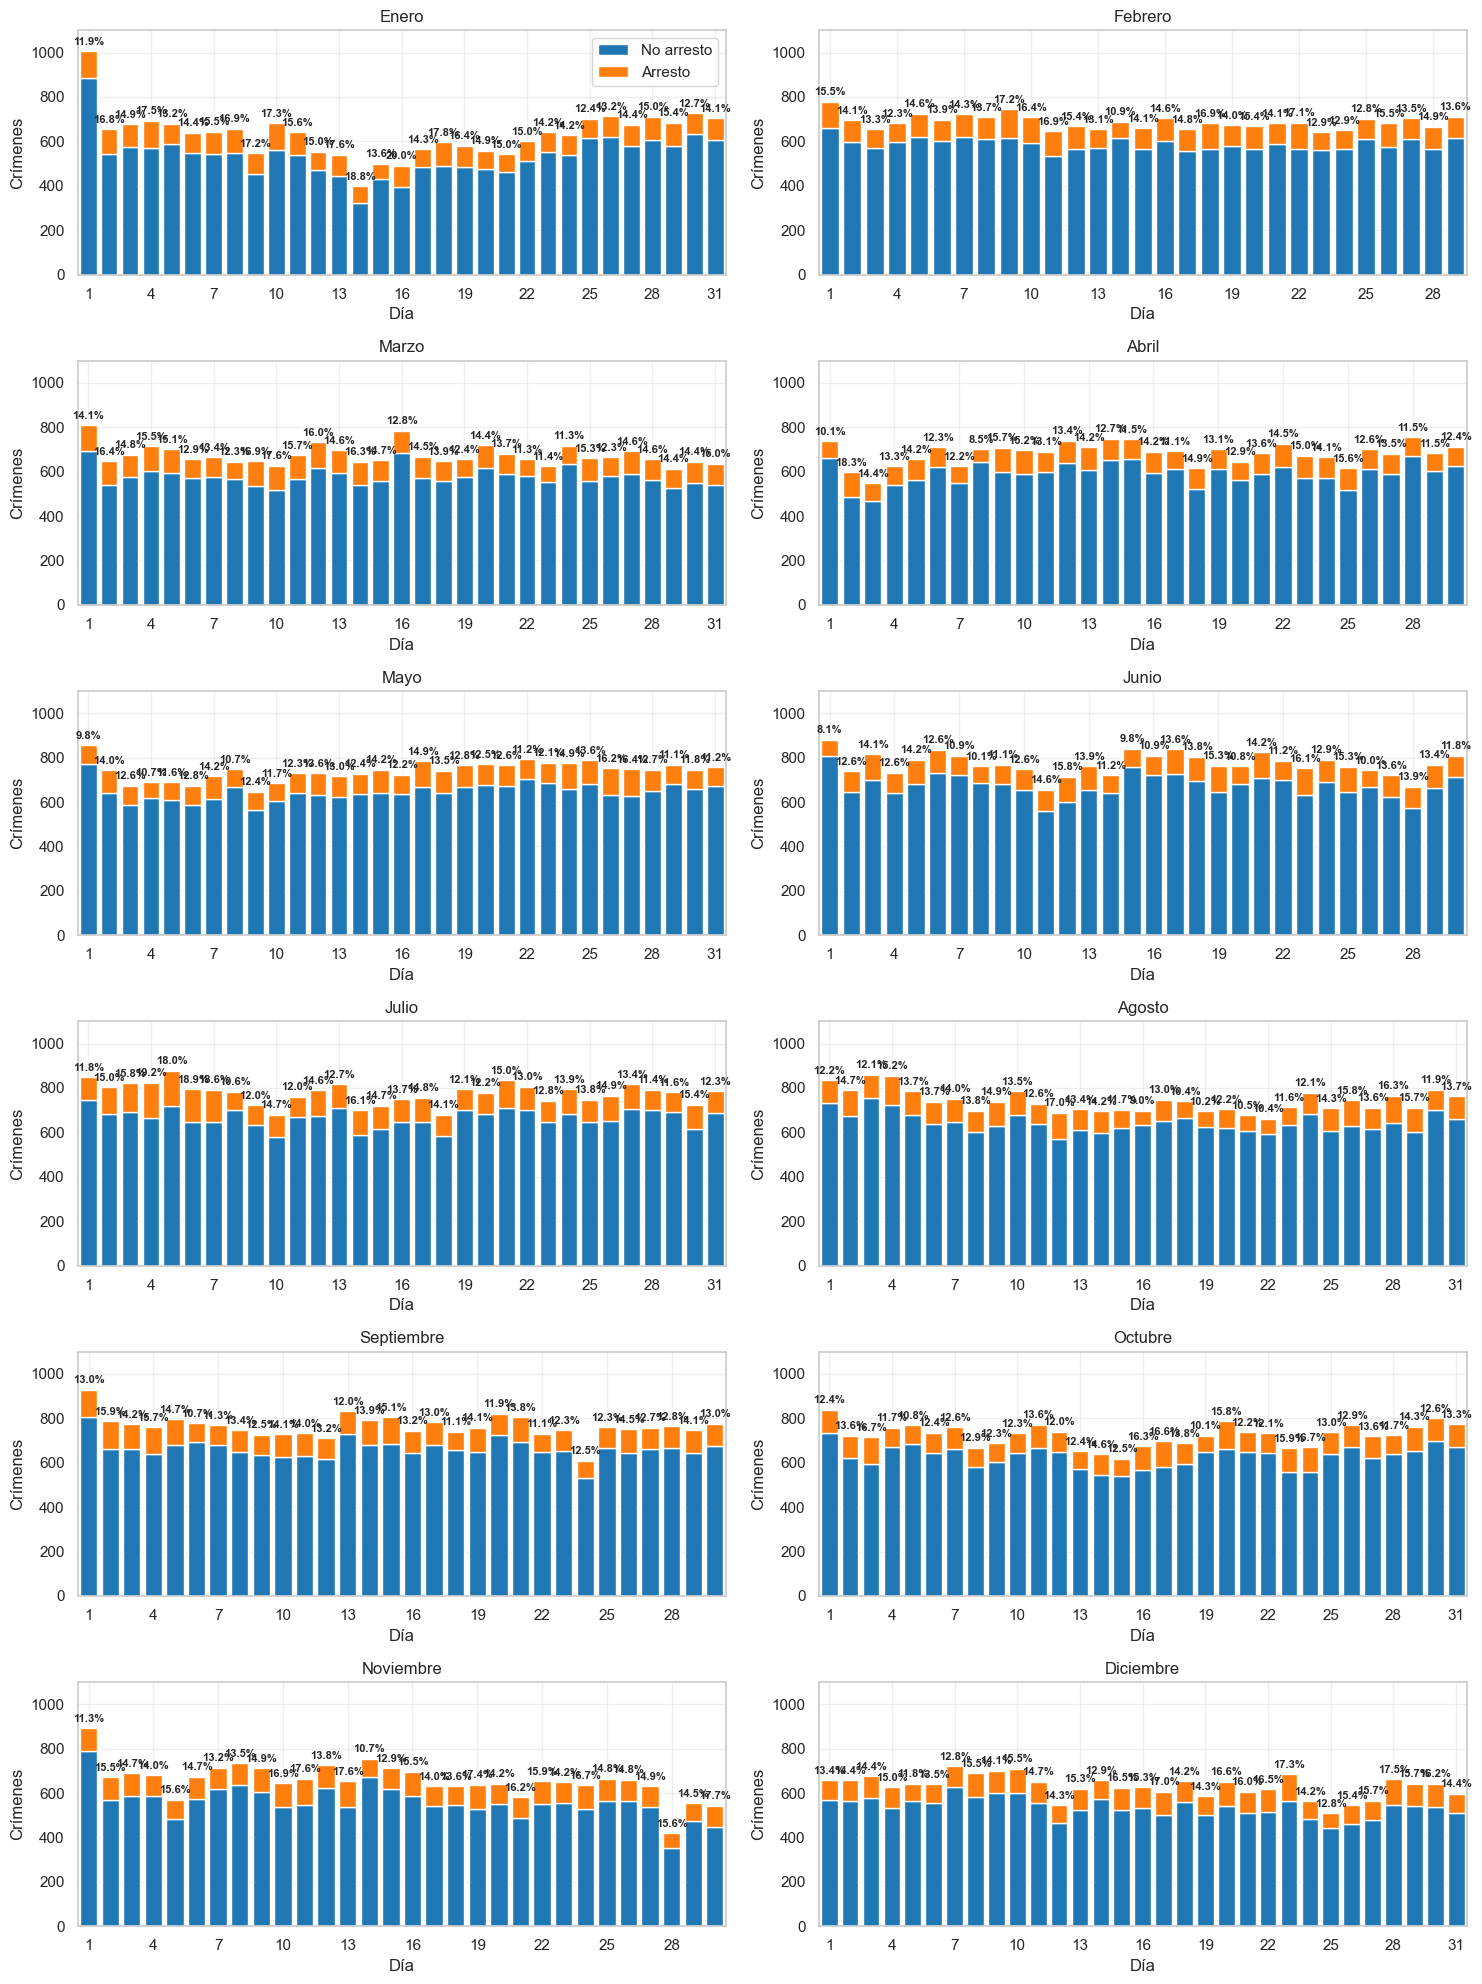

In [9]:
fig, axs = plt.subplots(6, 2, figsize=(15, 20))
axs = axs.flatten()

max_y = 1100
for i, mes in enumerate(sorted(df['Month'].unique()), 0):
    datos_mes = df[df['Month'] == mes]
    ultimo_dia = calendar.monthrange(2024, mes)[1]
    dias_mes = np.arange(1, ultimo_dia + 1)

    # Agrupar por día y arresto
    conteo = datos_mes.groupby([datos_mes['Date_raw'].dt.day, 'Arrest']).size().unstack(fill_value=0)
    conteo = conteo.reindex(dias_mes, fill_value=0)

    totales = conteo[False] + conteo[True]
    porcentajes = 100 * conteo[True] / totales.replace(0, np.nan)

    # Barras apiladas: primero los no arrestos, luego los arrestos
    axs[i].bar(dias_mes, conteo[False], label='No arresto', color='#1f77b4')
    axs[i].bar(dias_mes, conteo[True], bottom=conteo[False], label='Arresto', color='#ff7f0e')

    axs[i].set_title(nombres_meses[mes])
    axs[i].set_xlabel("Día")
    axs[i].set_ylabel("Crímenes")
    axs[i].set_xlim(0.5, ultimo_dia + 0.5)
    axs[i].set_xticks(range(1, ultimo_dia + 1, 3))
    axs[i].set_ylim(0, max_y)
    axs[i].grid(True, alpha=0.3)
    if i == 0:
        axs[i].legend()

    for idx, pct in enumerate(porcentajes):
        if not np.isnan(pct):
            axs[i].text(
                idx + 1, totales.iloc[idx] + 20,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=8, fontweight='bold'
            )

plt.tight_layout()
plt.show()

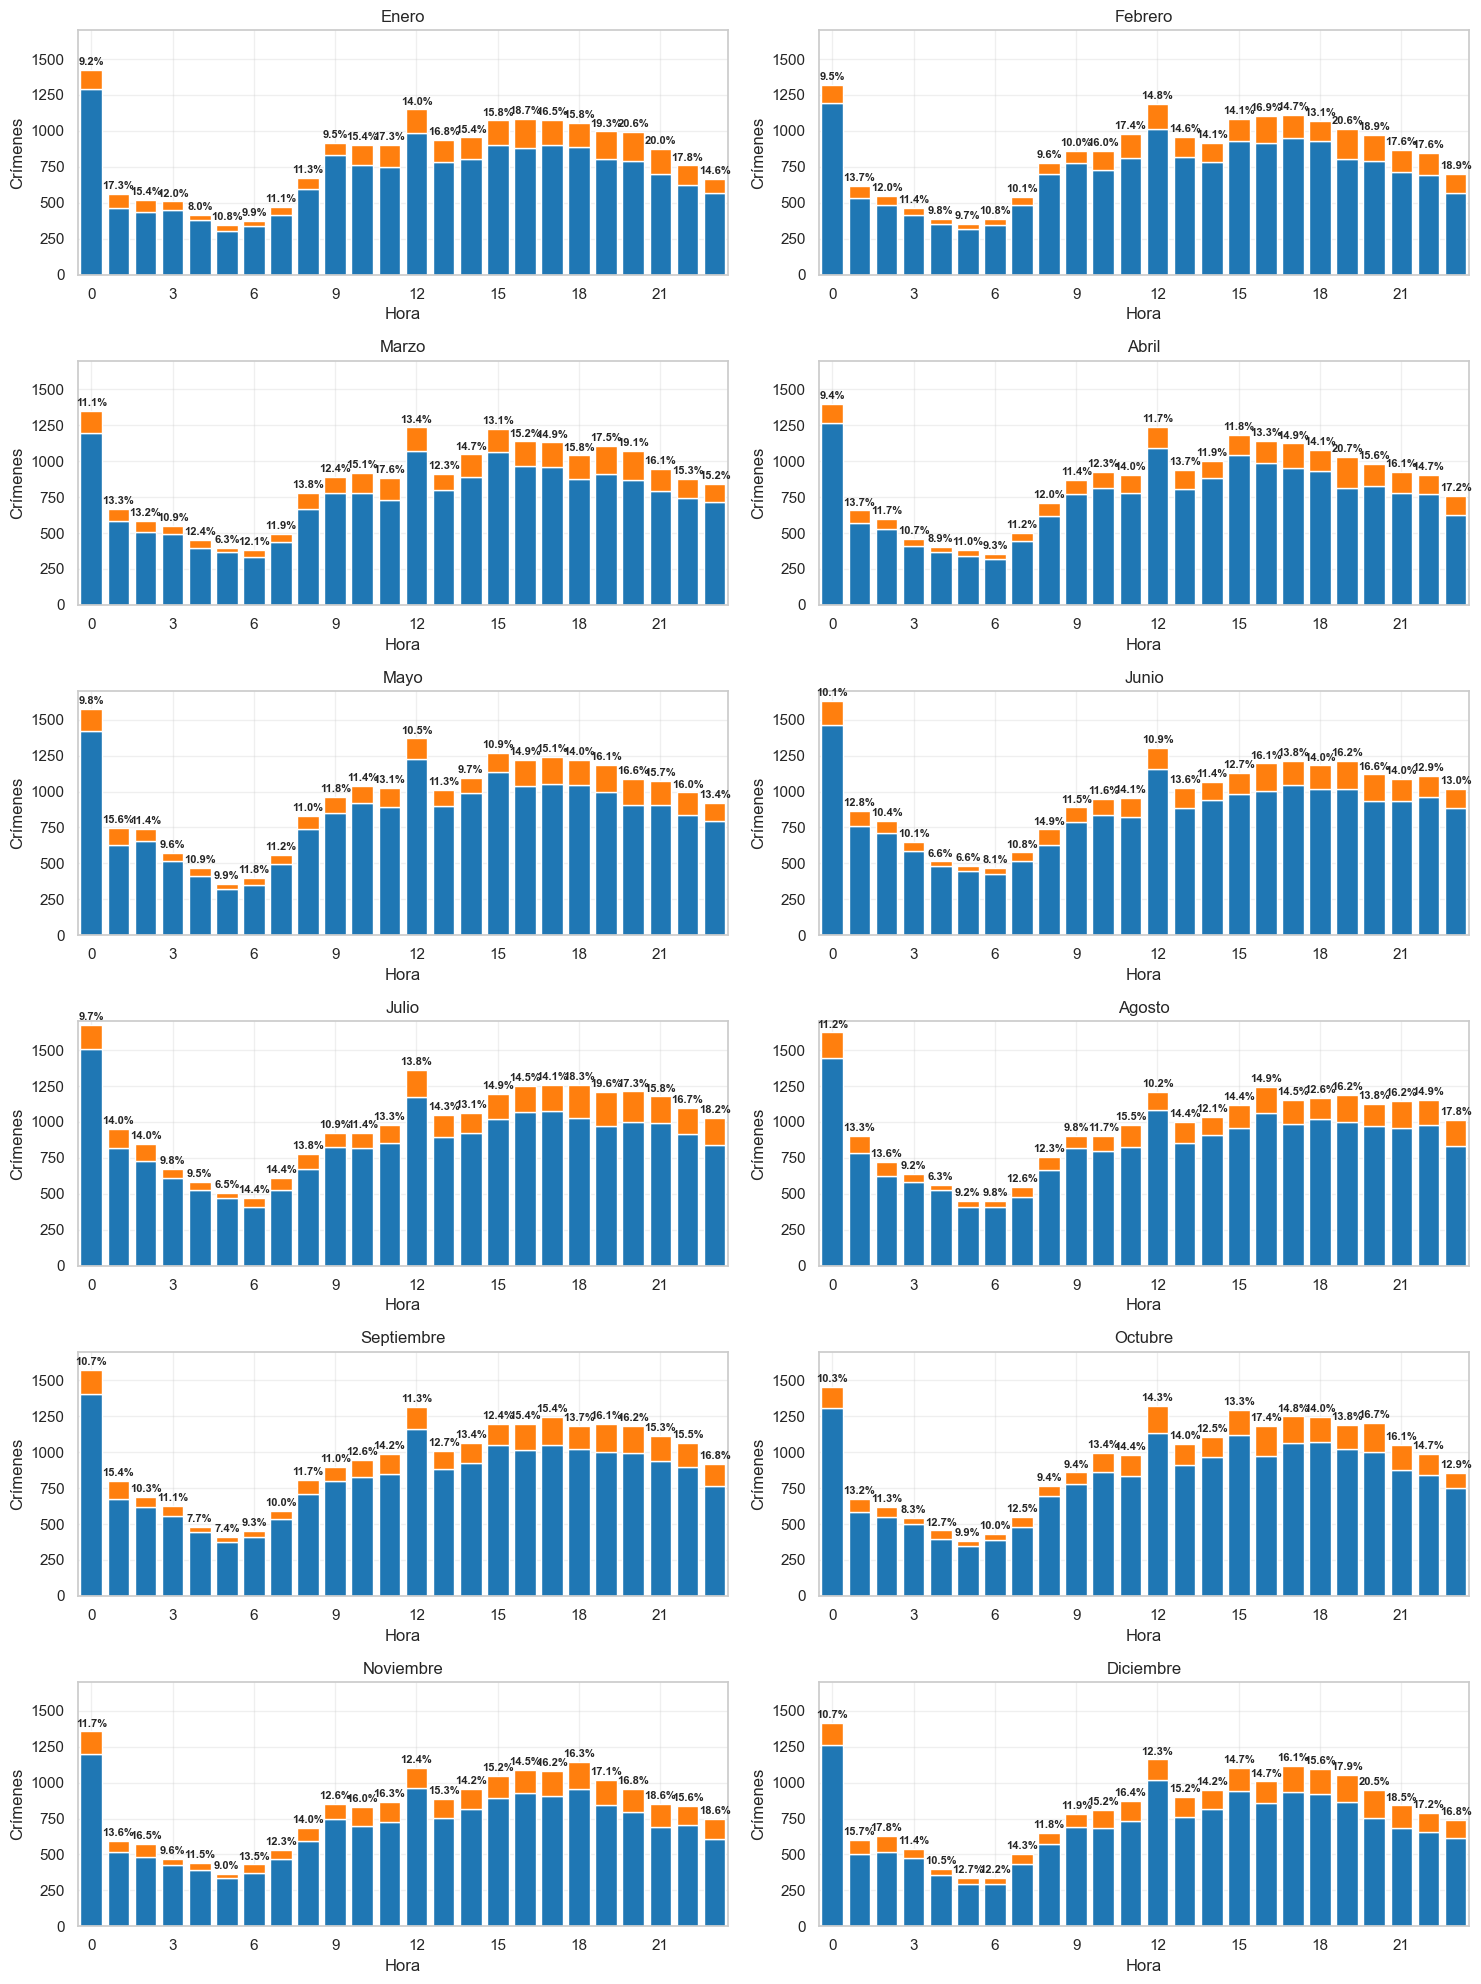

In [10]:
fig, axs = plt.subplots(6, 2, figsize=(15, 20))
axs = axs.flatten()

max_y = 1700
for i, mes in enumerate(sorted(df['Month'].unique()), 0):
    datos_mes_h = df[df['Month'] == mes]

    # Contar crímenes por hora y rellenar horas faltantes con 0
    horas = np.arange(0, 24)
    conteo = datos_mes_h.groupby([datos_mes_h['Date_raw'].dt.hour, 'Arrest']).size().unstack(fill_value=0)
    conteo = conteo.reindex(horas, fill_value=0)

    totales = conteo[False] + conteo[True]
    porcentajes = 100 * conteo[True] / totales.replace(0, np.nan)

    axs[i].bar(horas, conteo[False], label='No arresto', color='#1f77b4')
    axs[i].bar(horas, conteo[True], bottom=conteo[False], label='Arresto', color='#ff7f0e')

    axs[i].set_title(nombres_meses[mes])
    axs[i].set_xlabel("Hora")
    axs[i].set_ylabel("Crímenes")
    axs[i].set_xlim(-0.5, 23.5)
    axs[i].set_xticks(range(0, 24, 3))
    axs[i].set_ylim(0, max_y)
    axs[i].grid(True, alpha=0.3)

    for idx, pct in enumerate(porcentajes):
        if not np.isnan(pct):
            axs[i].text(
                idx, totales.iloc[idx] + 20,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=8, fontweight='bold'
            )

plt.tight_layout()
plt.show()

### Crímenes agrupados por ubicación/espacio

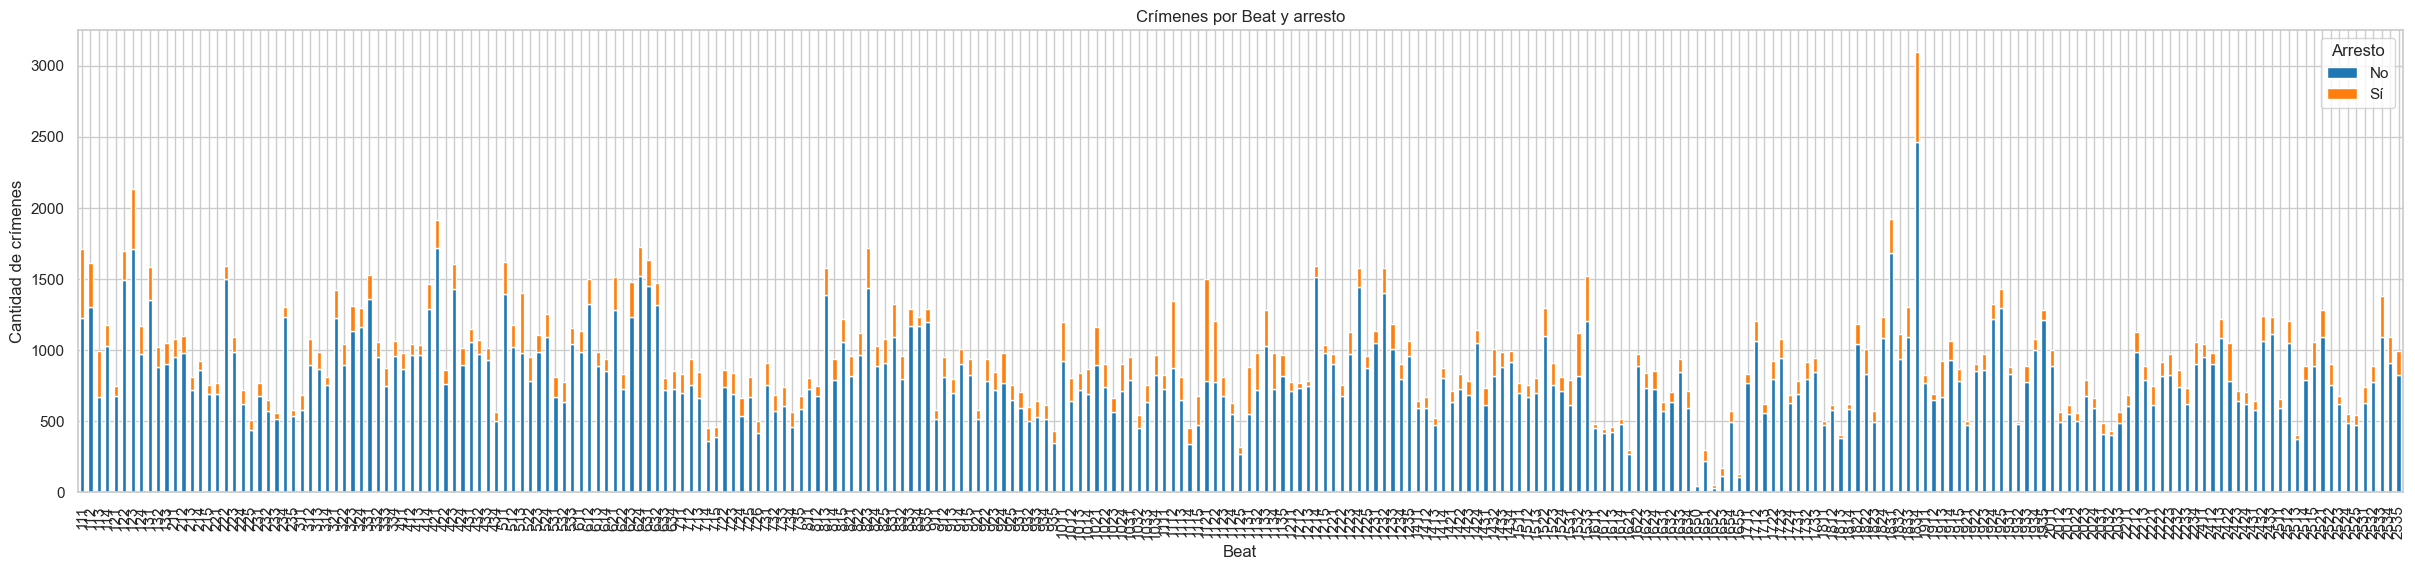

In [11]:
crimenes_beat_arresto = df.groupby(['Beat', 'Arrest']).size().unstack(fill_value=False)
totales = crimenes_beat_arresto[False] + crimenes_beat_arresto[True]
porcentajes = 100 * crimenes_beat_arresto[True] / totales.replace(0, np.nan)

ax = crimenes_beat_arresto.plot(
    kind='bar',
    stacked=True,
    figsize=(30, 6),
    color=['#1f77b4', '#ff7f0e']
)

# for idx, pct in enumerate(porcentajes):
#     if not np.isnan(pct):
#         ax.text(
#             idx, totales.iloc[idx] + 5,
#             f'{pct:.1f}%',
#             ha='center', va='bottom', fontsize=10, fontweight='bold'
#         )
#     print('Beat ', idx, ':', pct)

plt.title('Crímenes por Beat y arresto')
plt.xlabel('Beat')
plt.ylabel('Cantidad de crímenes')
plt.legend(title='Arresto', labels=['No', 'Sí'])
plt.show()

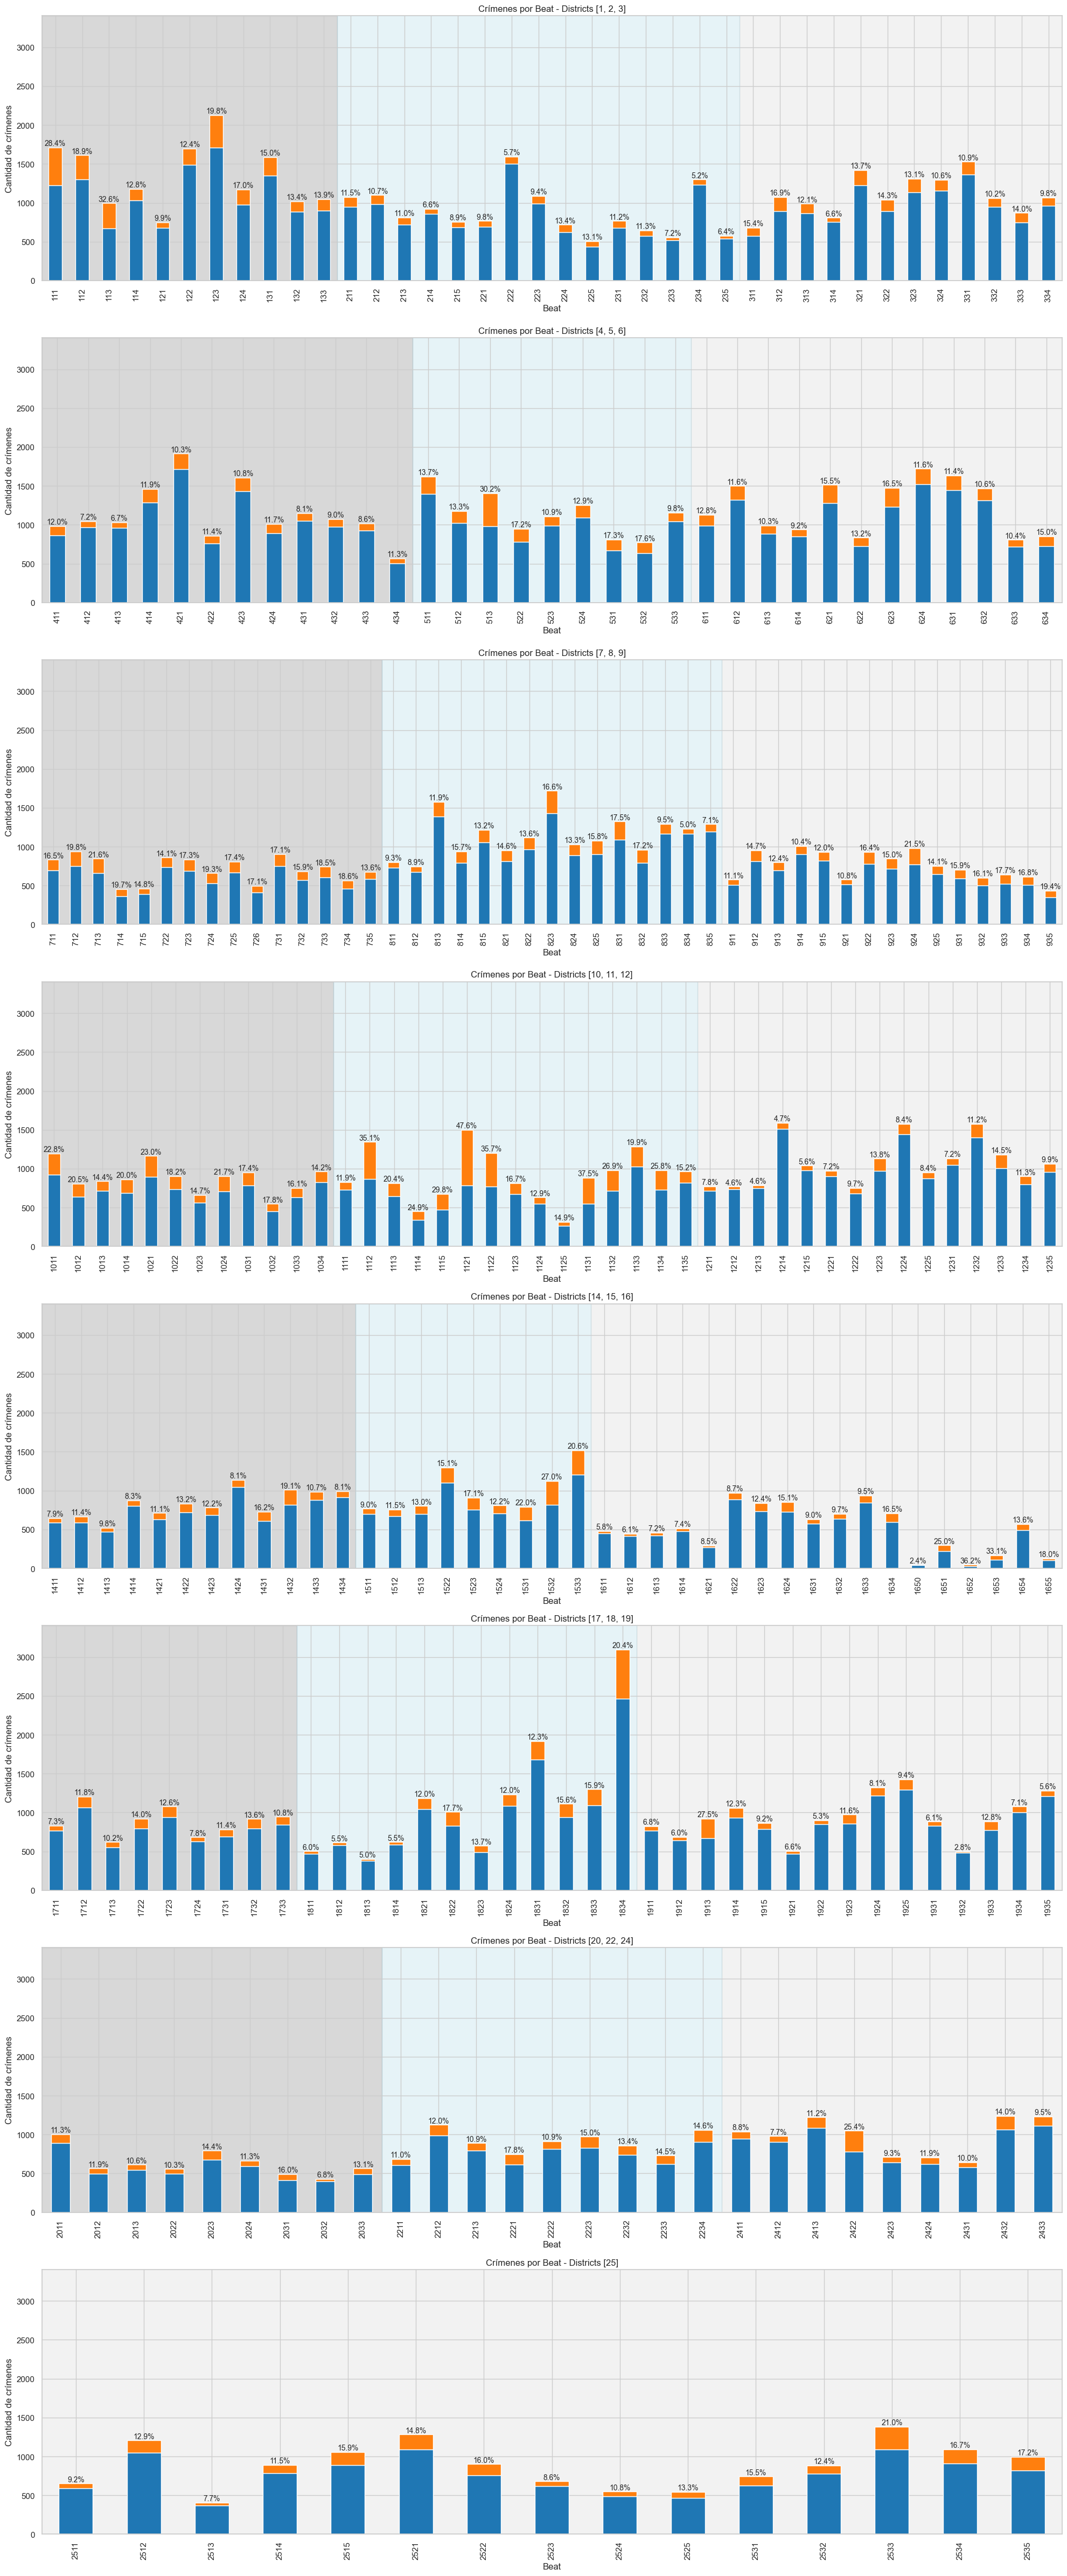

In [12]:
# Agrupar por Beat y Arresto
crimenes_beat_arresto = df.groupby(['Beat', 'Arrest']).size().unstack(fill_value=0)
crimenes_beat_arresto.index = crimenes_beat_arresto.index.astype(int)
crimenes_beat_arresto = crimenes_beat_arresto.sort_index()

totales = crimenes_beat_arresto[False] + crimenes_beat_arresto[True]
porcentajes = 100 * crimenes_beat_arresto[True] / totales.replace(0, np.nan)

# Crear un mapeo de Beat a District
beat_to_district = df.groupby('Beat')['District'].first().astype(int).to_dict()

# Obtener lista ordenada de Districts únicos
districts_ordered = sorted(df['District'].astype(int).unique())

# Agrupar Districts en grupos de 3
districts_per_plot = 3
district_splits = [districts_ordered[i:i+districts_per_plot] for i in range(0, len(districts_ordered), districts_per_plot)]

# Crear splits de Beats basados en Districts
beat_splits = []
for district_group in district_splits:
    beats_in_group = [beat for beat in crimenes_beat_arresto.index.tolist() 
                      if beat_to_district.get(beat) in district_group]
    if beats_in_group:
        beat_splits.append(beats_in_group)

number_of_plots = len(beat_splits)

fig, axs = plt.subplots(number_of_plots, 1, figsize=(20, 6 * number_of_plots))

# Manejar el caso de un único subplot
if number_of_plots == 1:
    axs = [axs]

for i, beat_group in enumerate(beat_splits):
    subset = crimenes_beat_arresto.loc[beat_group]
    totales_sub = totales.loc[beat_group]
    porcentajes_sub = porcentajes.loc[beat_group]
    ax = axs[i]
    subset.plot(
        kind='bar',
        stacked=True,
        color=['#1f77b4', '#ff7f0e'],
        ax=ax,
        legend=False,
    )
    
    # Pintar fondo alternando colores cada vez que cambia District
    current_district = None
    start_idx = 0
    color_idx = 0
    colors = ['grey', 'lightblue']
    
    for idx, beat in enumerate(beat_group):
        beat_district = beat_to_district.get(beat)
        if beat_district != current_district and idx > 0:
            # Cambió de district, pintar el rango anterior
            ax.axvspan(start_idx - 0.5, idx - 0.5, color=colors[color_idx % 2], 
                       alpha=0.3, zorder=0)
            color_idx += 1
            start_idx = idx
            current_district = beat_district
        elif idx == 0:
            current_district = beat_district
    
    # Pintar el último rango
    ax.axvspan(start_idx - 0.5, len(beat_group) - 0.5, color=colors[color_idx % 2], 
               alpha=0.1, zorder=0)
    
    # Etiquetas de porcentaje
    for idx, pct in enumerate(porcentajes_sub):
        if not np.isnan(pct):
            ax.text(
                idx, totales_sub.iloc[idx] + 5,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=10
            )

        # print('Beat ', beat_group[idx], ':', pct)
    
    districts_in_plot = sorted(set(beat_to_district.get(beat) for beat in beat_group))
    ax.set_title(f'Crímenes por Beat - Districts {districts_in_plot}')
    ax.set_xlabel('Beat')
    ax.set_ylabel('Cantidad de crímenes')
    ax.set_ylim(0, totales.max() * 1.1)

plt.tight_layout()
plt.show()

In [13]:
# Se guarda el porcentaje de arretos por Beat como nueva columna en el DataFrame original
# df['Arrests Ratio'] = df['Beat'].map(porcentajes)
# df.head()

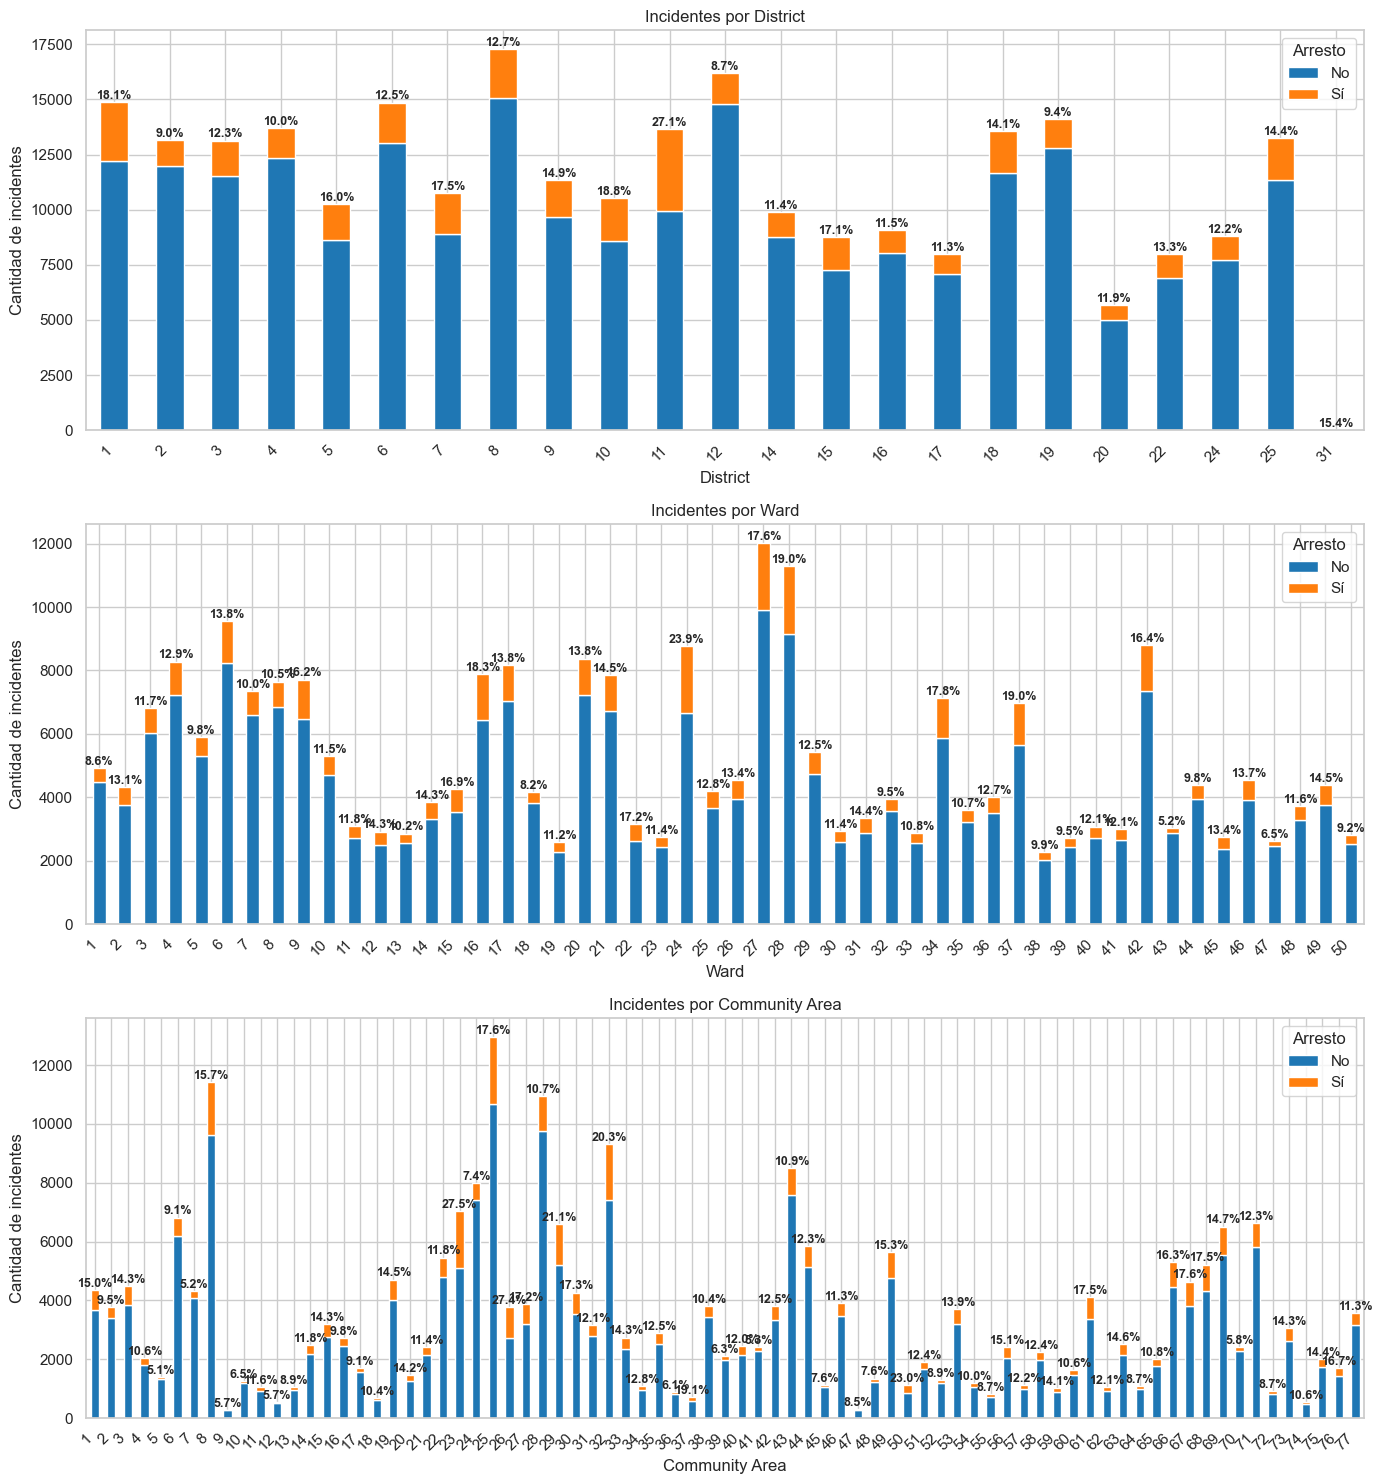

In [14]:
cols = ['District', 'Ward', 'Community Area']

fig, axs = plt.subplots(len(cols), 1, figsize=(14, 5 * len(cols)))
for ax, col in zip(axs, cols):
    datos_col = df.groupby([col, 'Arrest']).size().unstack(fill_value=0)
    
    totales = datos_col[False] + datos_col[True]
    porcentajes = 100 * datos_col[True] / totales.replace(0, np.nan)

    datos_col.plot(
        kind='bar',
        stacked=True,
        ax=ax,
        color=['#1f77b4', '#ff7f0e'],
        legend=False
    )
    
    # Agregar etiquetas de porcentaje
    for idx, pct in enumerate(porcentajes):
        if not np.isnan(pct):
            ax.text(
                idx, totales.iloc[idx] + 5,
                f'{pct:.1f}%',
                ha='center', va='bottom', fontsize=9, fontweight='bold'
            )
    ax.set_xticks(range(len(datos_col.index)))
    ax.set_xticklabels(datos_col.index, rotation=45, ha='right')
    
    ax.set_ylabel('Cantidad de incidentes')
    ax.set_title(f'Incidentes por {col}')
    ax.legend(title='Arresto', labels=['No', 'Sí'])
    
plt.tight_layout()
plt.show()

In [15]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from shapely import wkt


# Opciones para mejor visualización
pd.set_option('display.max_columns', None)

In [16]:
beats = gpd.read_file('lib/PoliceBeatDec2012_20251123.csv')

beats['geometry'] = beats['the_geom'].apply(wkt.loads)
beats = gpd.GeoDataFrame(beats, geometry='geometry')
# beats.head()
beats.crs  # comprobar sistema de coordenadas

# Normalizar nombres de columna
beats['BEAT_NUM'] = beats['BEAT_NUM'].astype(str).str.zfill(4)
df['BEAT'] = df['Beat'].astype(int).astype(str).str.zfill(4)

# Agrupar
counts = df.groupby('BEAT').size().reset_index(name='crime_count')
arrest_count = df[df['Arrest'] == True].groupby('BEAT').size().reset_index(name='arrest_count')

# Unir con los polígonos
beats = beats.astype({'BEAT_NUM': str})  # asegurar que coincidan tipos
beats = beats.merge(counts, left_on='BEAT_NUM', right_on='BEAT', how='left')

# Los beats sin crímenes tendrán NaN -> convertir a 0
beats['crime_count'] = beats['crime_count'].fillna(0)
beats['crime_count'] = beats['crime_count'].astype('int64')

beats['ARREST_RATIO'] = beats['BEAT_NUM'].map(
    (arrest_count.set_index('BEAT')['arrest_count'] / counts.set_index('BEAT')['crime_count']).fillna(0)
)
# beats.head()

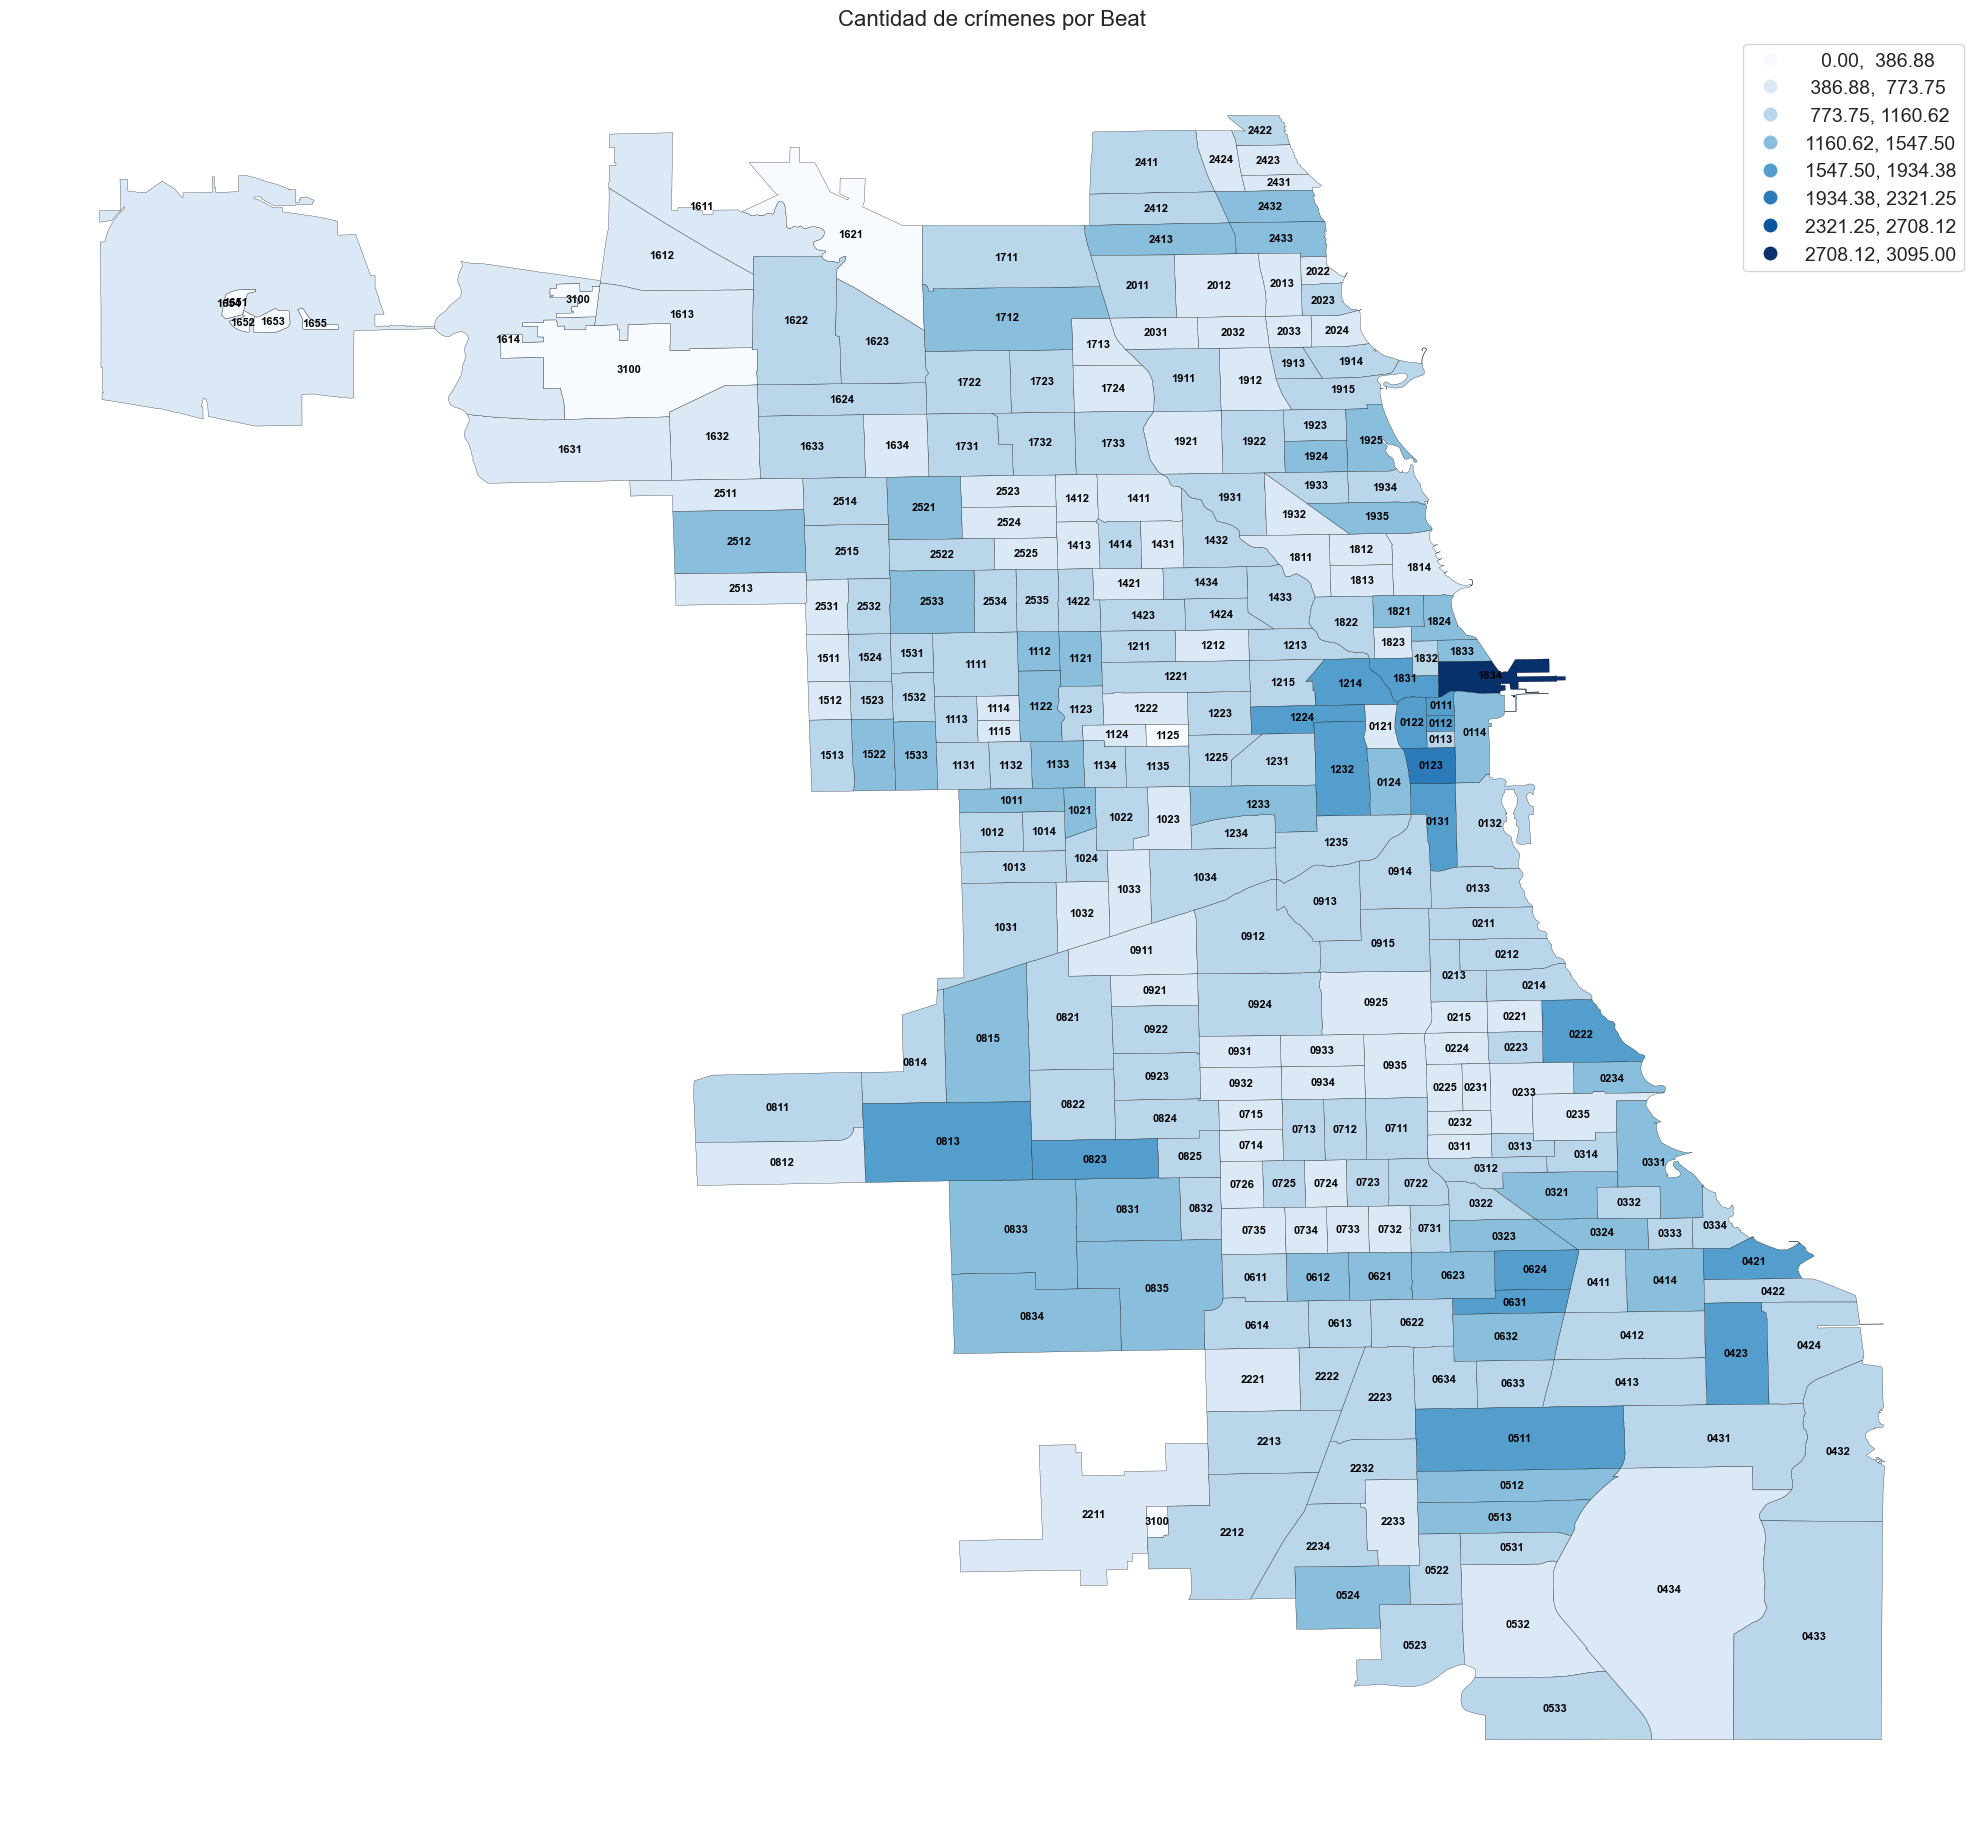

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
beats.plot(
    column='crime_count',
    cmap='Blues',
    scheme='equal_interval',
    k=8,
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    ax=ax,
    legend_kwds={'fontsize': 14}
)

for idx, row in beats.iterrows():
    centroid = row['geometry'].centroid
    ax.text(
        centroid.x, centroid.y,
        str(row['BEAT_NUM']),
        ha='center', va='center',
        fontsize=8,
        fontweight='bold',
        color='black'
    )

ax.set_title('Cantidad de crímenes por Beat', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

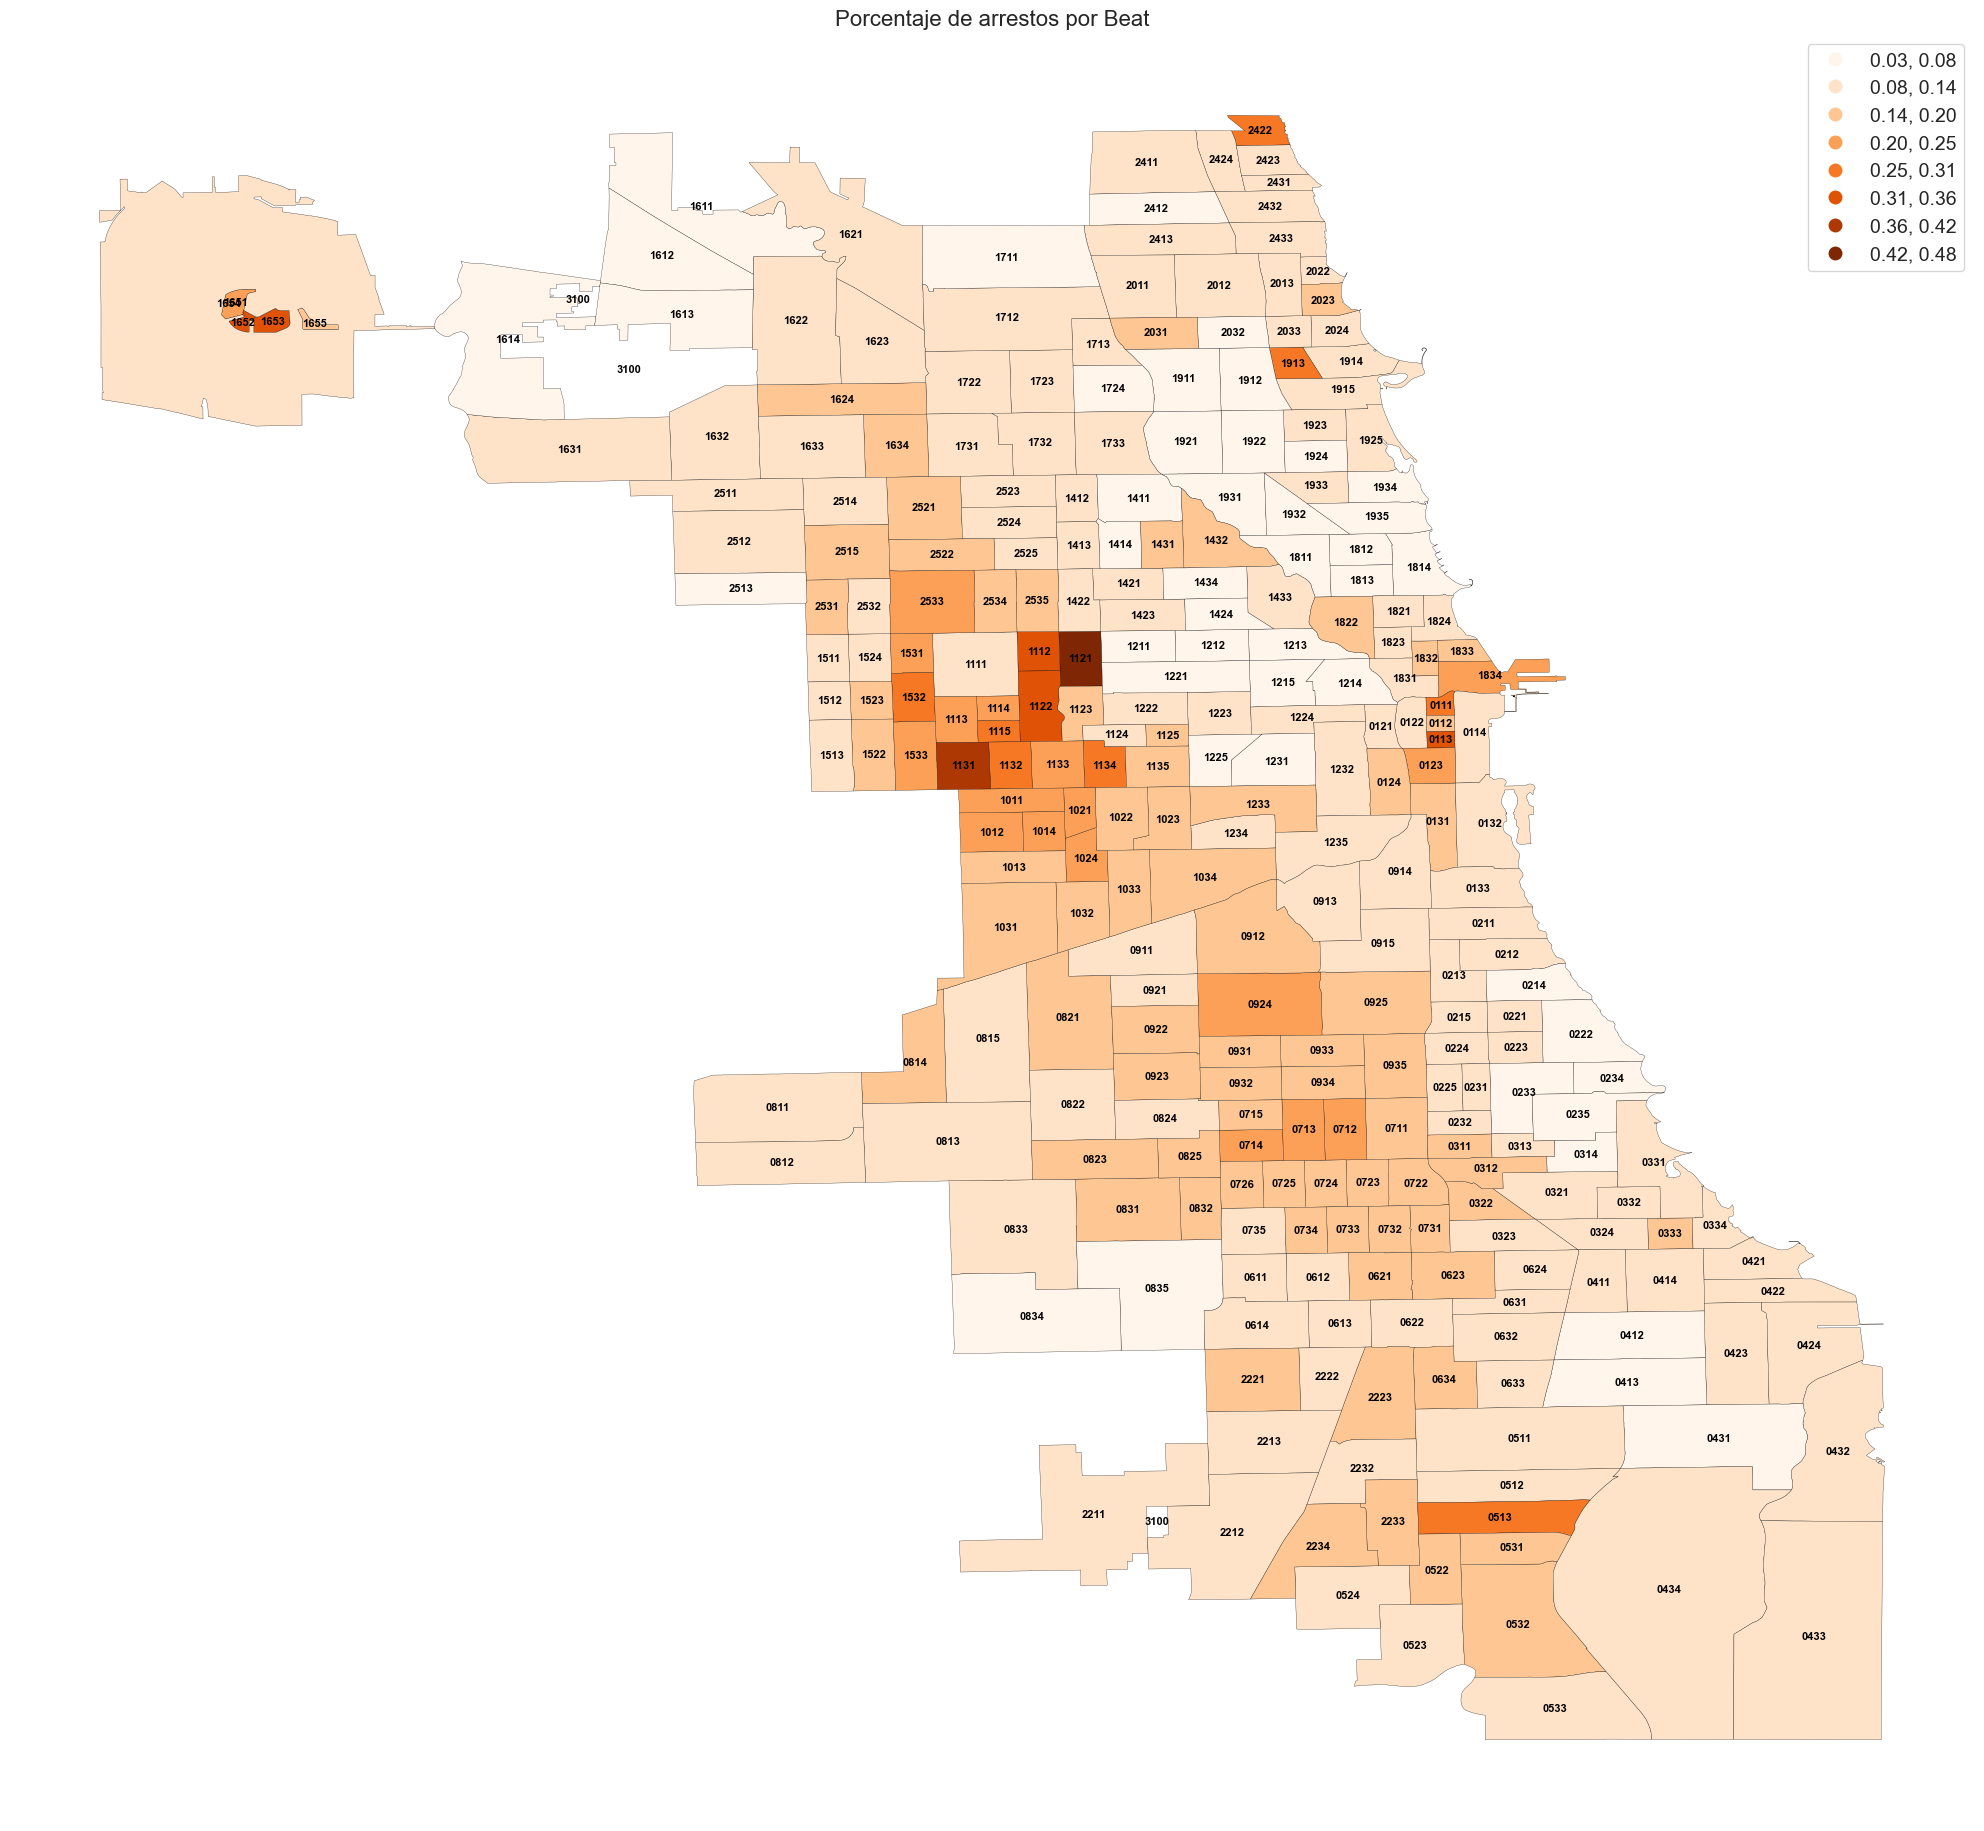

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
beats.plot(
    'ARREST_RATIO',
    cmap='Oranges',
    scheme='equal_interval',
    k=8,
    legend=True,
    edgecolor='black',
    linewidth=0.2,
    ax=ax,
    legend_kwds={'fontsize': 14}
)

for idx, row in beats.iterrows():
    centroid = row['geometry'].centroid
    ax.text(
        centroid.x, centroid.y,
        str(row['BEAT_NUM']),
        ha='center', va='center',
        fontsize=8,
        fontweight='bold',
        color='black'
    )

ax.set_title('Porcentaje de arrestos por Beat', fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

In [19]:
from matplotlib.patches import Patch

<function matplotlib.pyplot.show(close=None, block=None)>

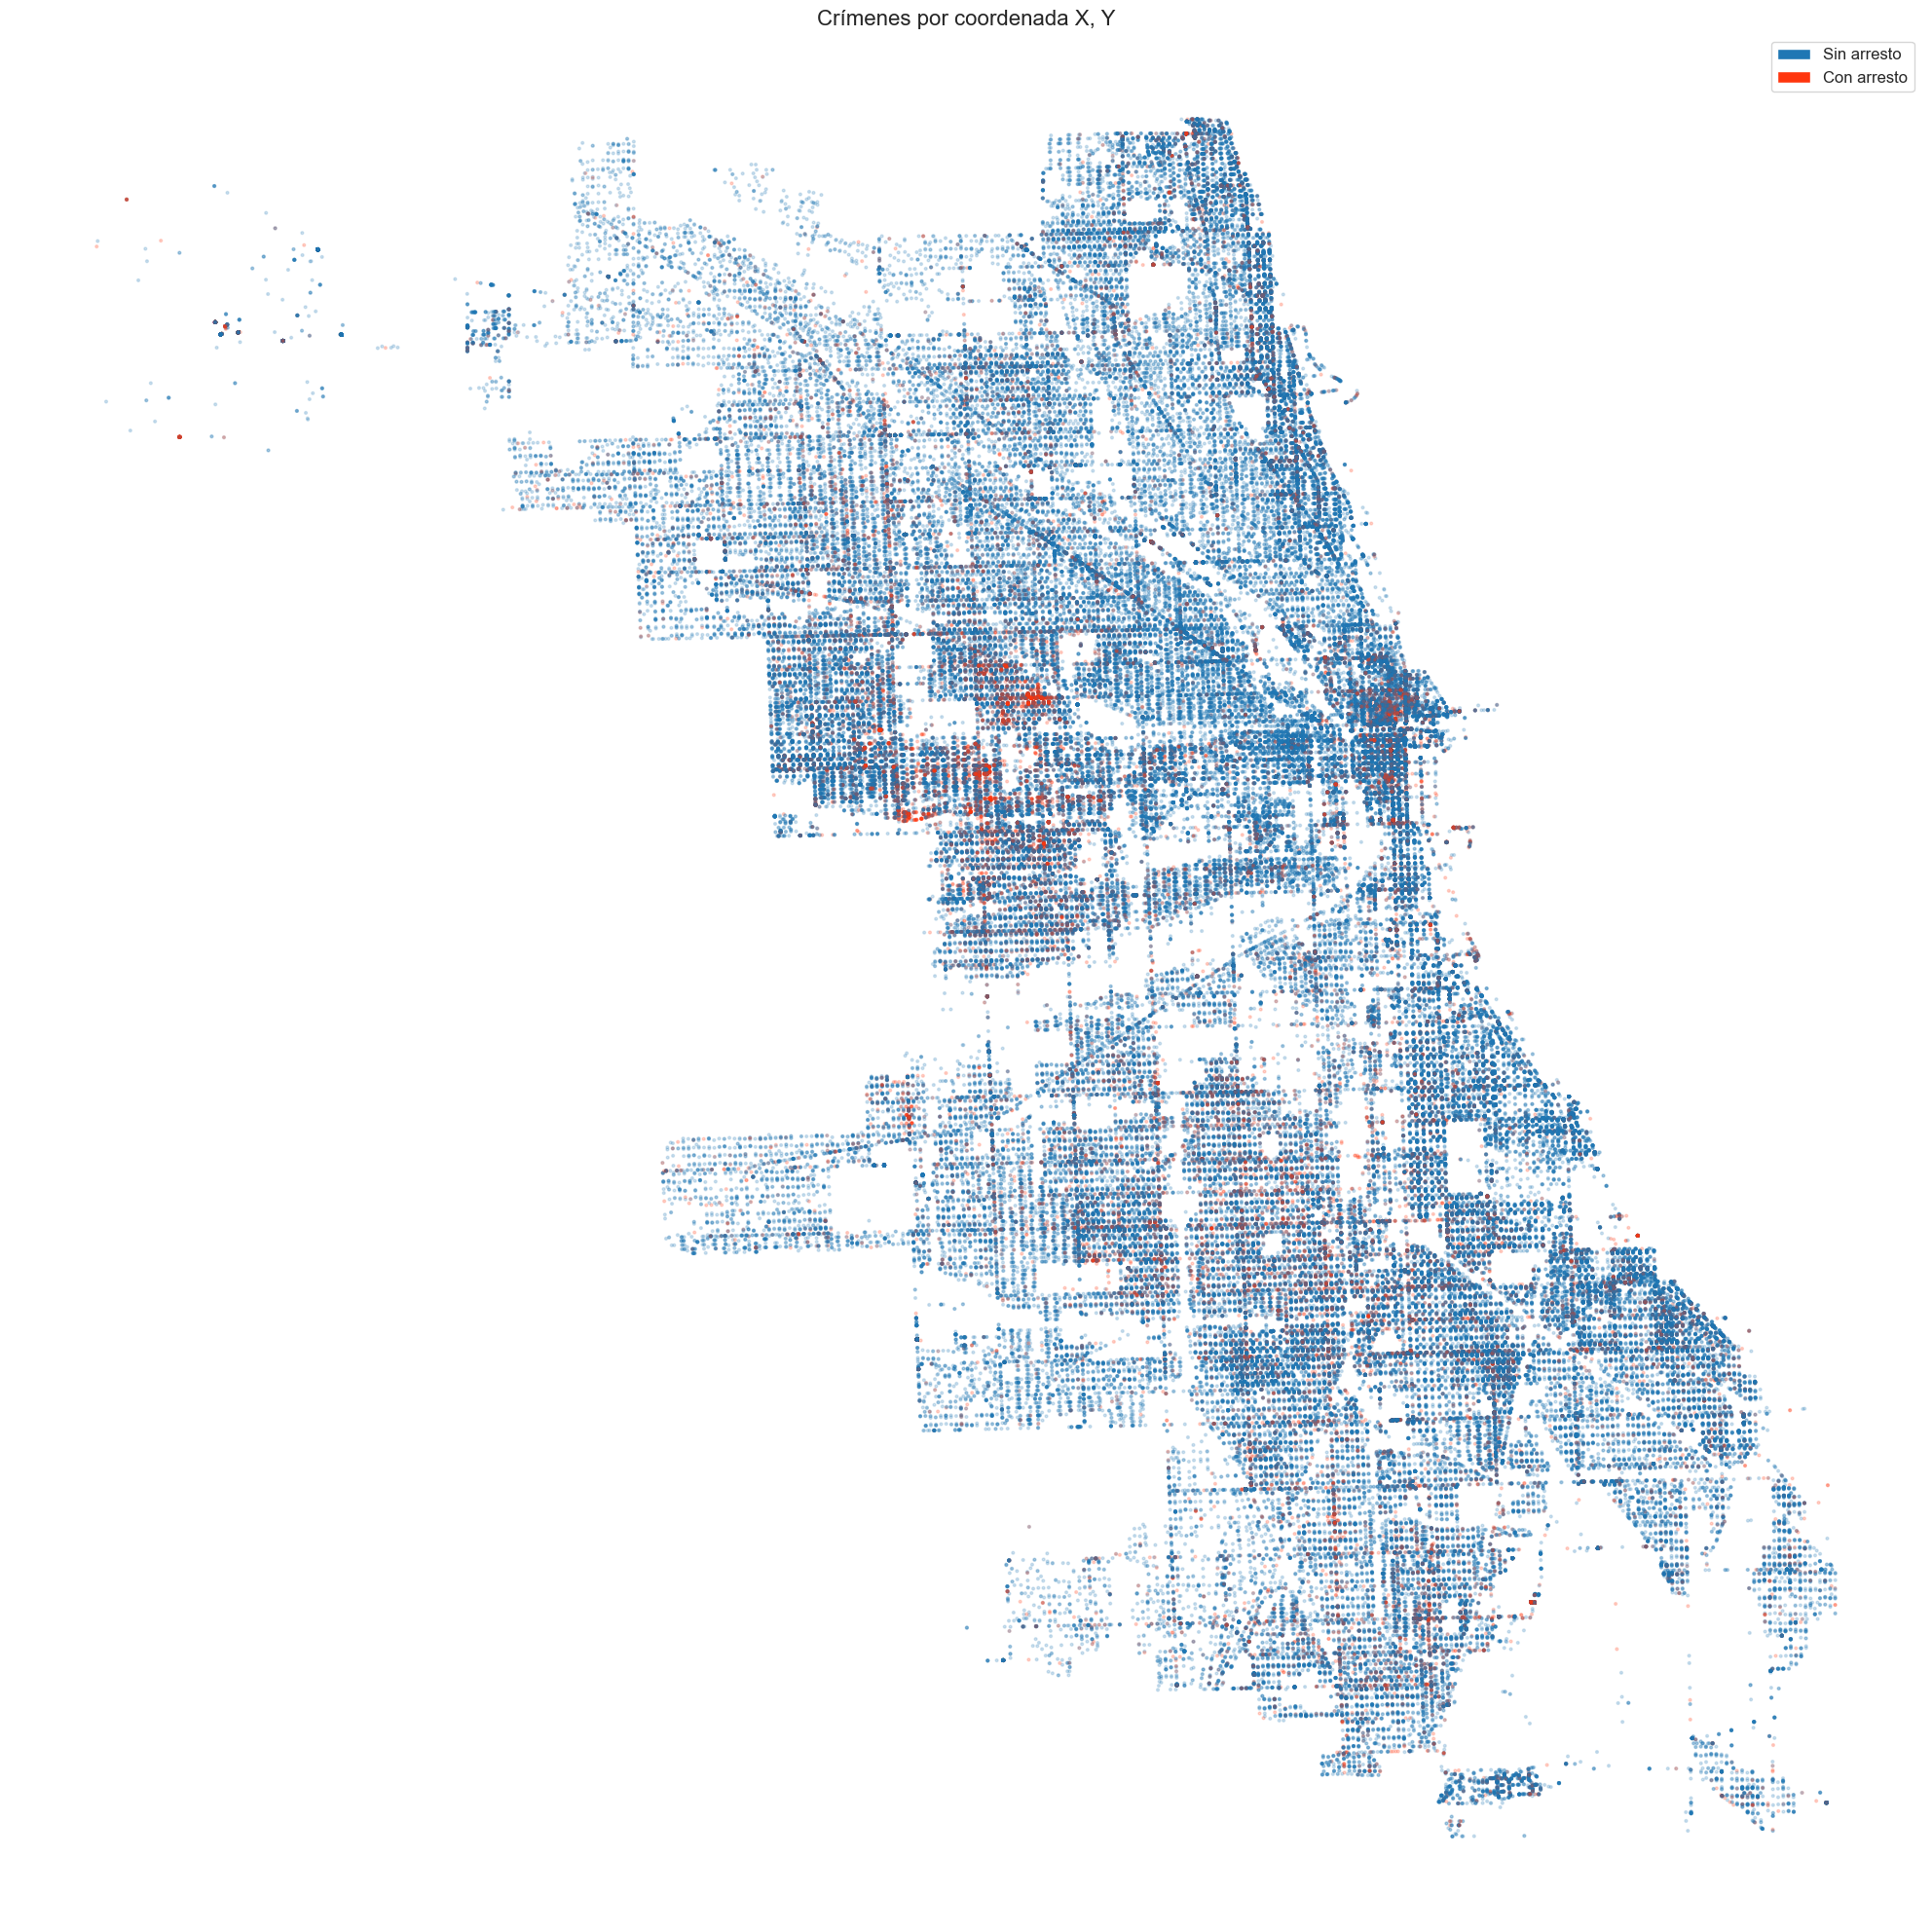

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

colors = df['Arrest'].map({False: '#1f77b4', True: "#ff360e"})
ax.scatter(
    df['X Coordinate'],
    df['Y Coordinate'], 
    alpha=0.2,
    s=4,
    c=colors
)
ax.set_title('Crímenes por coordenada X, Y', fontsize=16)
ax.axis('off')

legend_elements = [
    Patch(facecolor='#1f77b4', label='Sin arresto'),
    Patch(facecolor='#ff360e', label='Con arresto')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
plt.tight_layout()
plt.show

### Crímenes agrupados por clasificación

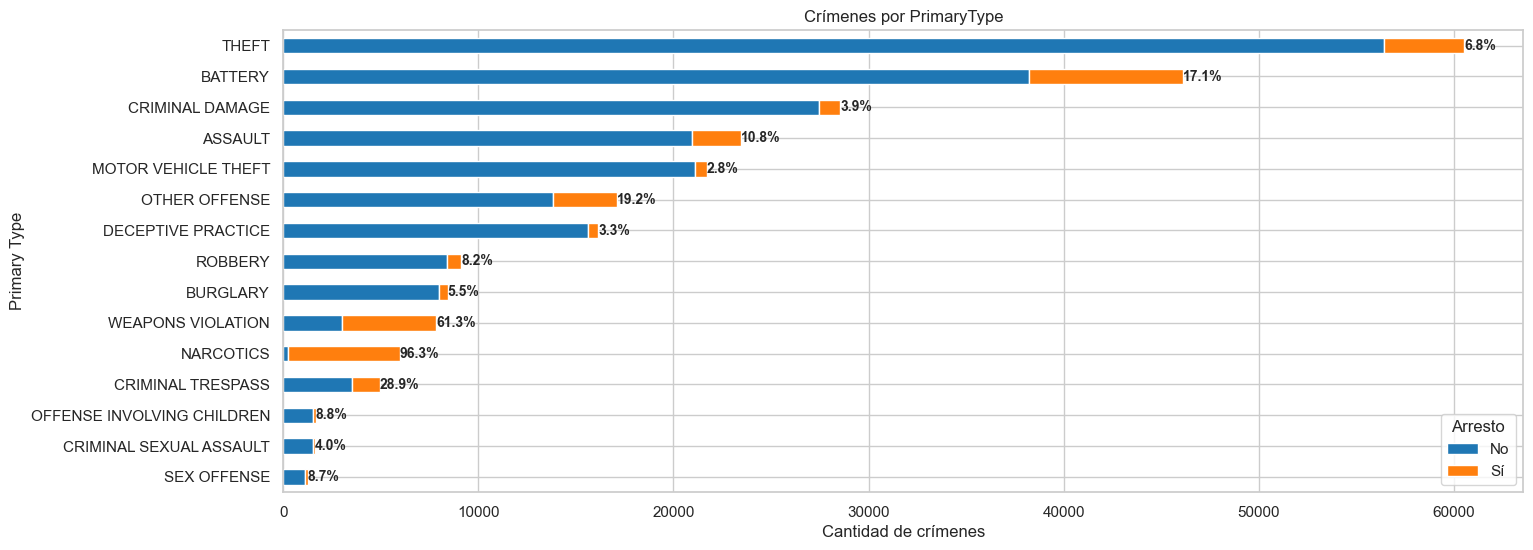

In [44]:
# largest_pt = df['Primary Type', 'Arrest'].value_counts().nlargest(10, 'Primary Type')
top_pt = df['Primary Type'].value_counts().nlargest(15).index.tolist()

crimenes_pt_arresto = (
    df[df['Primary Type'].isin(top_pt)]
    .groupby(['Primary Type', 'Arrest'])
    .size()
    .unstack(fill_value=0)
)

crimenes_pt_arresto['total'] = crimenes_pt_arresto.sum(axis=1)
crimenes_pt_arresto = crimenes_pt_arresto.sort_values('total', ascending=True).drop(columns='total')

totales = crimenes_pt_arresto[False] + crimenes_pt_arresto[True]
porcentajes = 100 * crimenes_pt_arresto[True] / totales.replace(0, np.nan)

ax = crimenes_pt_arresto.plot(
    kind='barh',
    stacked=True,
    figsize=(16,6),
    color=['#1f77b4', '#ff7f0e']
)

for idx, pct in enumerate(porcentajes):
    if not np.isnan(pct):
        ax.text(
            totales.iloc[idx], idx,
            f'{pct:.1f}%', 
            ha='left', va='center', fontsize=10, fontweight='bold'
        )

plt.title('Crímenes por PrimaryType')
plt.ylabel('Primary Type')
plt.xlabel('Cantidad de crímenes')
plt.legend(title='Arresto', labels=['No', 'Sí'])
plt.show()

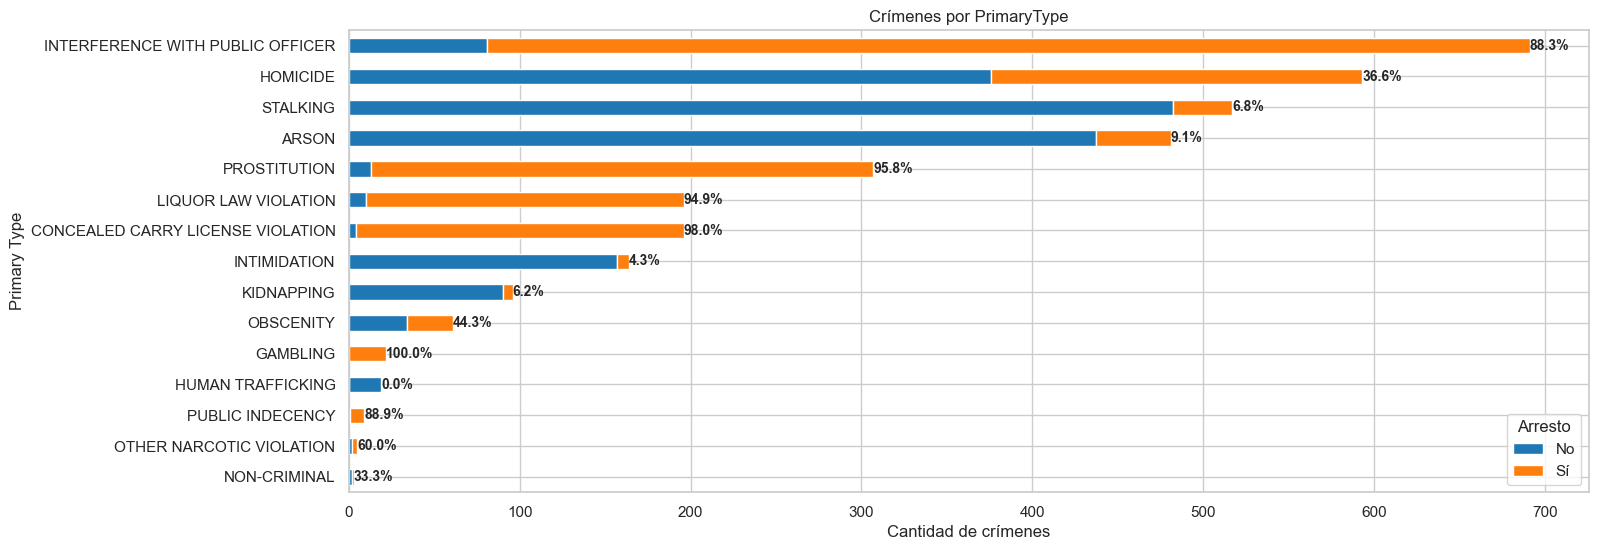

In [45]:
top_pt = df['Primary Type'].value_counts().nsmallest(15).index.tolist()

crimenes_pt_arresto = (
    df[df['Primary Type'].isin(top_pt)]
    .groupby(['Primary Type', 'Arrest'])
    .size()
    .unstack(fill_value=0)
)

crimenes_pt_arresto['total'] = crimenes_pt_arresto.sum(axis=1)
crimenes_pt_arresto = crimenes_pt_arresto.sort_values('total', ascending=True).drop(columns='total')

totales = crimenes_pt_arresto[False] + crimenes_pt_arresto[True]
porcentajes = 100 * crimenes_pt_arresto[True] / totales.replace(0, np.nan)

ax = crimenes_pt_arresto.plot(
    kind='barh',
    stacked=True,
    figsize=(16,6),
    color=['#1f77b4', '#ff7f0e']
)

for idx, pct in enumerate(porcentajes):
    if not np.isnan(pct):
        ax.text(
            totales.iloc[idx], idx,
            f'{pct:.1f}%', 
            ha='left', va='center', fontsize=10, fontweight='bold'
        )

plt.title('Crímenes por PrimaryType')
plt.ylabel('Primary Type')
plt.xlabel('Cantidad de crímenes')
plt.legend(title='Arresto', labels=['No', 'Sí'])
plt.show()

El "Primary Type" del crimen viene ampliado por la variable "Description", es decir que le aporta algo más de detalle. Es una variable categórica cuyos posibles valores dependen del valor del mismo registro en la columna Primary Type. Se observan 319 valores únicos para esta columna.

Cada combinación de los feature "Primary Type" + "Description" es única y definida, y viene indicada en la columna "IUCR", por lo cual se puede utilizar solo este código para distinguirlas.
A continuación se grafica entonces, la cantidad de crímenes por código IUCR. Este gráfico no muestra a qué refiere cada código pero permite visualizar las variaciones entre ellos y, en caso de estar interesado en alguno en particular, puede remitirse al [listado](https://data.cityofchicago.org/d/c7ck-438e) del Chicago PD.

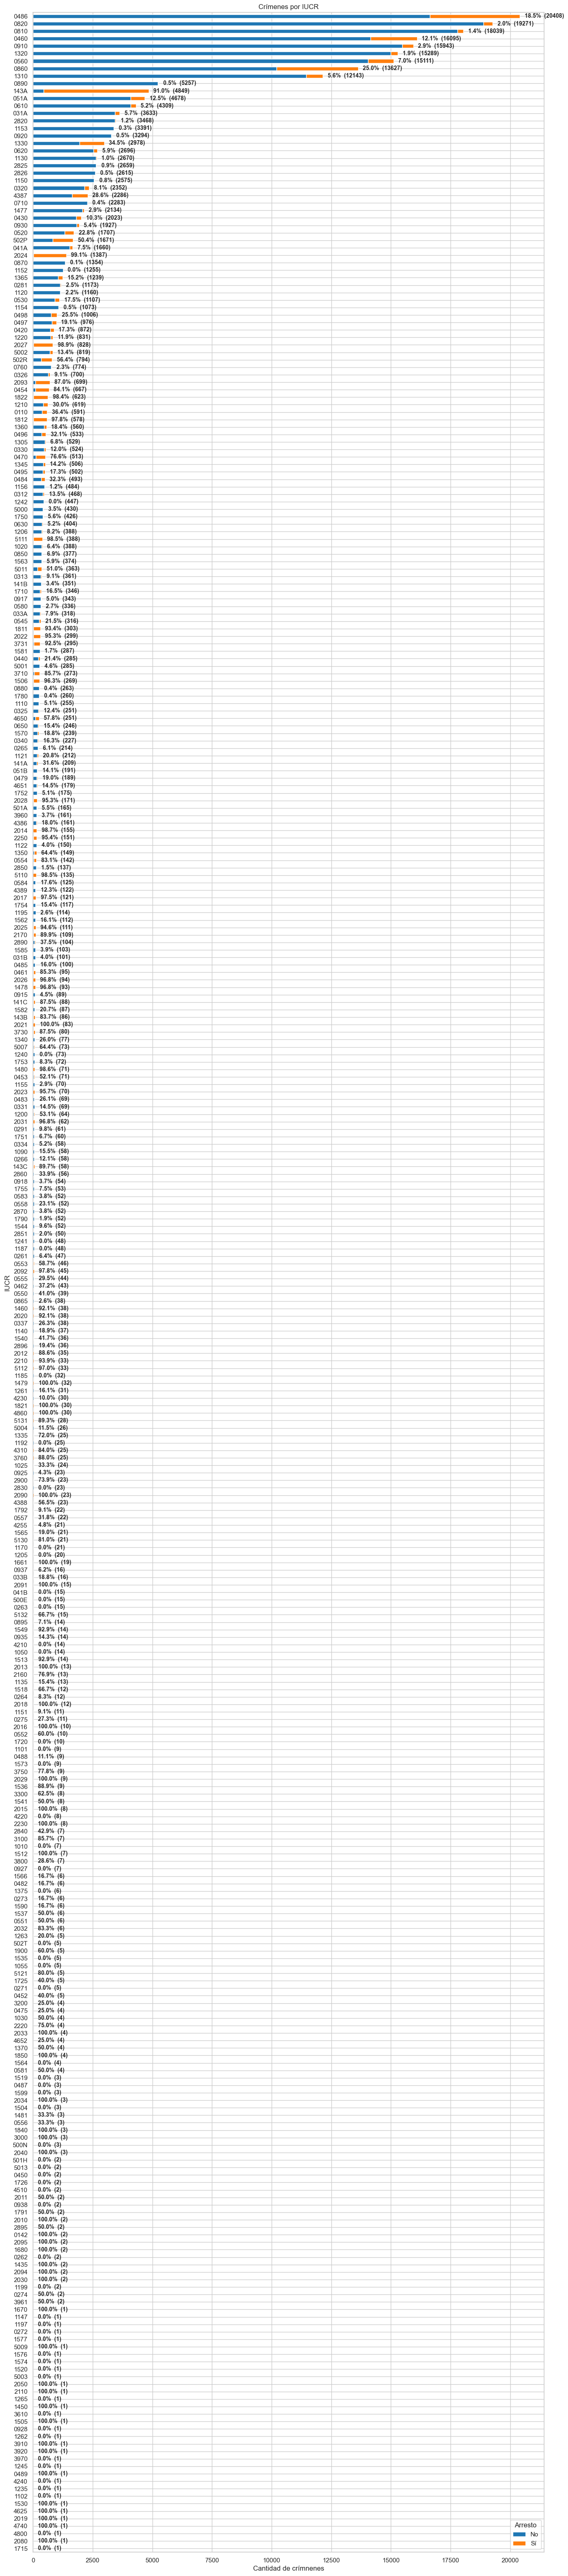

In [23]:
iucr_arresto = df.groupby(['IUCR', 'Arrest']).size().unstack(fill_value=0)

iucr_arresto['total'] = iucr_arresto.sum(axis=1)
iucr_arresto = iucr_arresto.sort_values('total', ascending=True).drop(columns='total')

totales = iucr_arresto[False] + iucr_arresto[True]
porcentajes = 100 * iucr_arresto[True] / totales.replace(0, np.nan)

ax = iucr_arresto.plot(
    kind='barh',
    stacked=True,
    figsize=(16,80),
    color=['#1f77b4', '#ff7f0e']
)
# print(totales[2])
for idx, pct in enumerate(porcentajes):
    if not np.isnan(pct):
        ax.text(
            totales.iloc[idx] + 200, idx,
            # f'{pct:.1f}%',
            f'{pct:.1f}%  ({totales.iloc[idx]})',
            ha='left', va='center', fontweight='bold', fontsize=10
        )

plt.title('Crímenes por IUCR')
plt.ylabel('IUCR')
plt.xlabel('Cantidad de crímnenes')
plt.legend(title='Arresto', labels=['No', 'Sí'])
# plt.xlim(0, 2500)
plt.show()

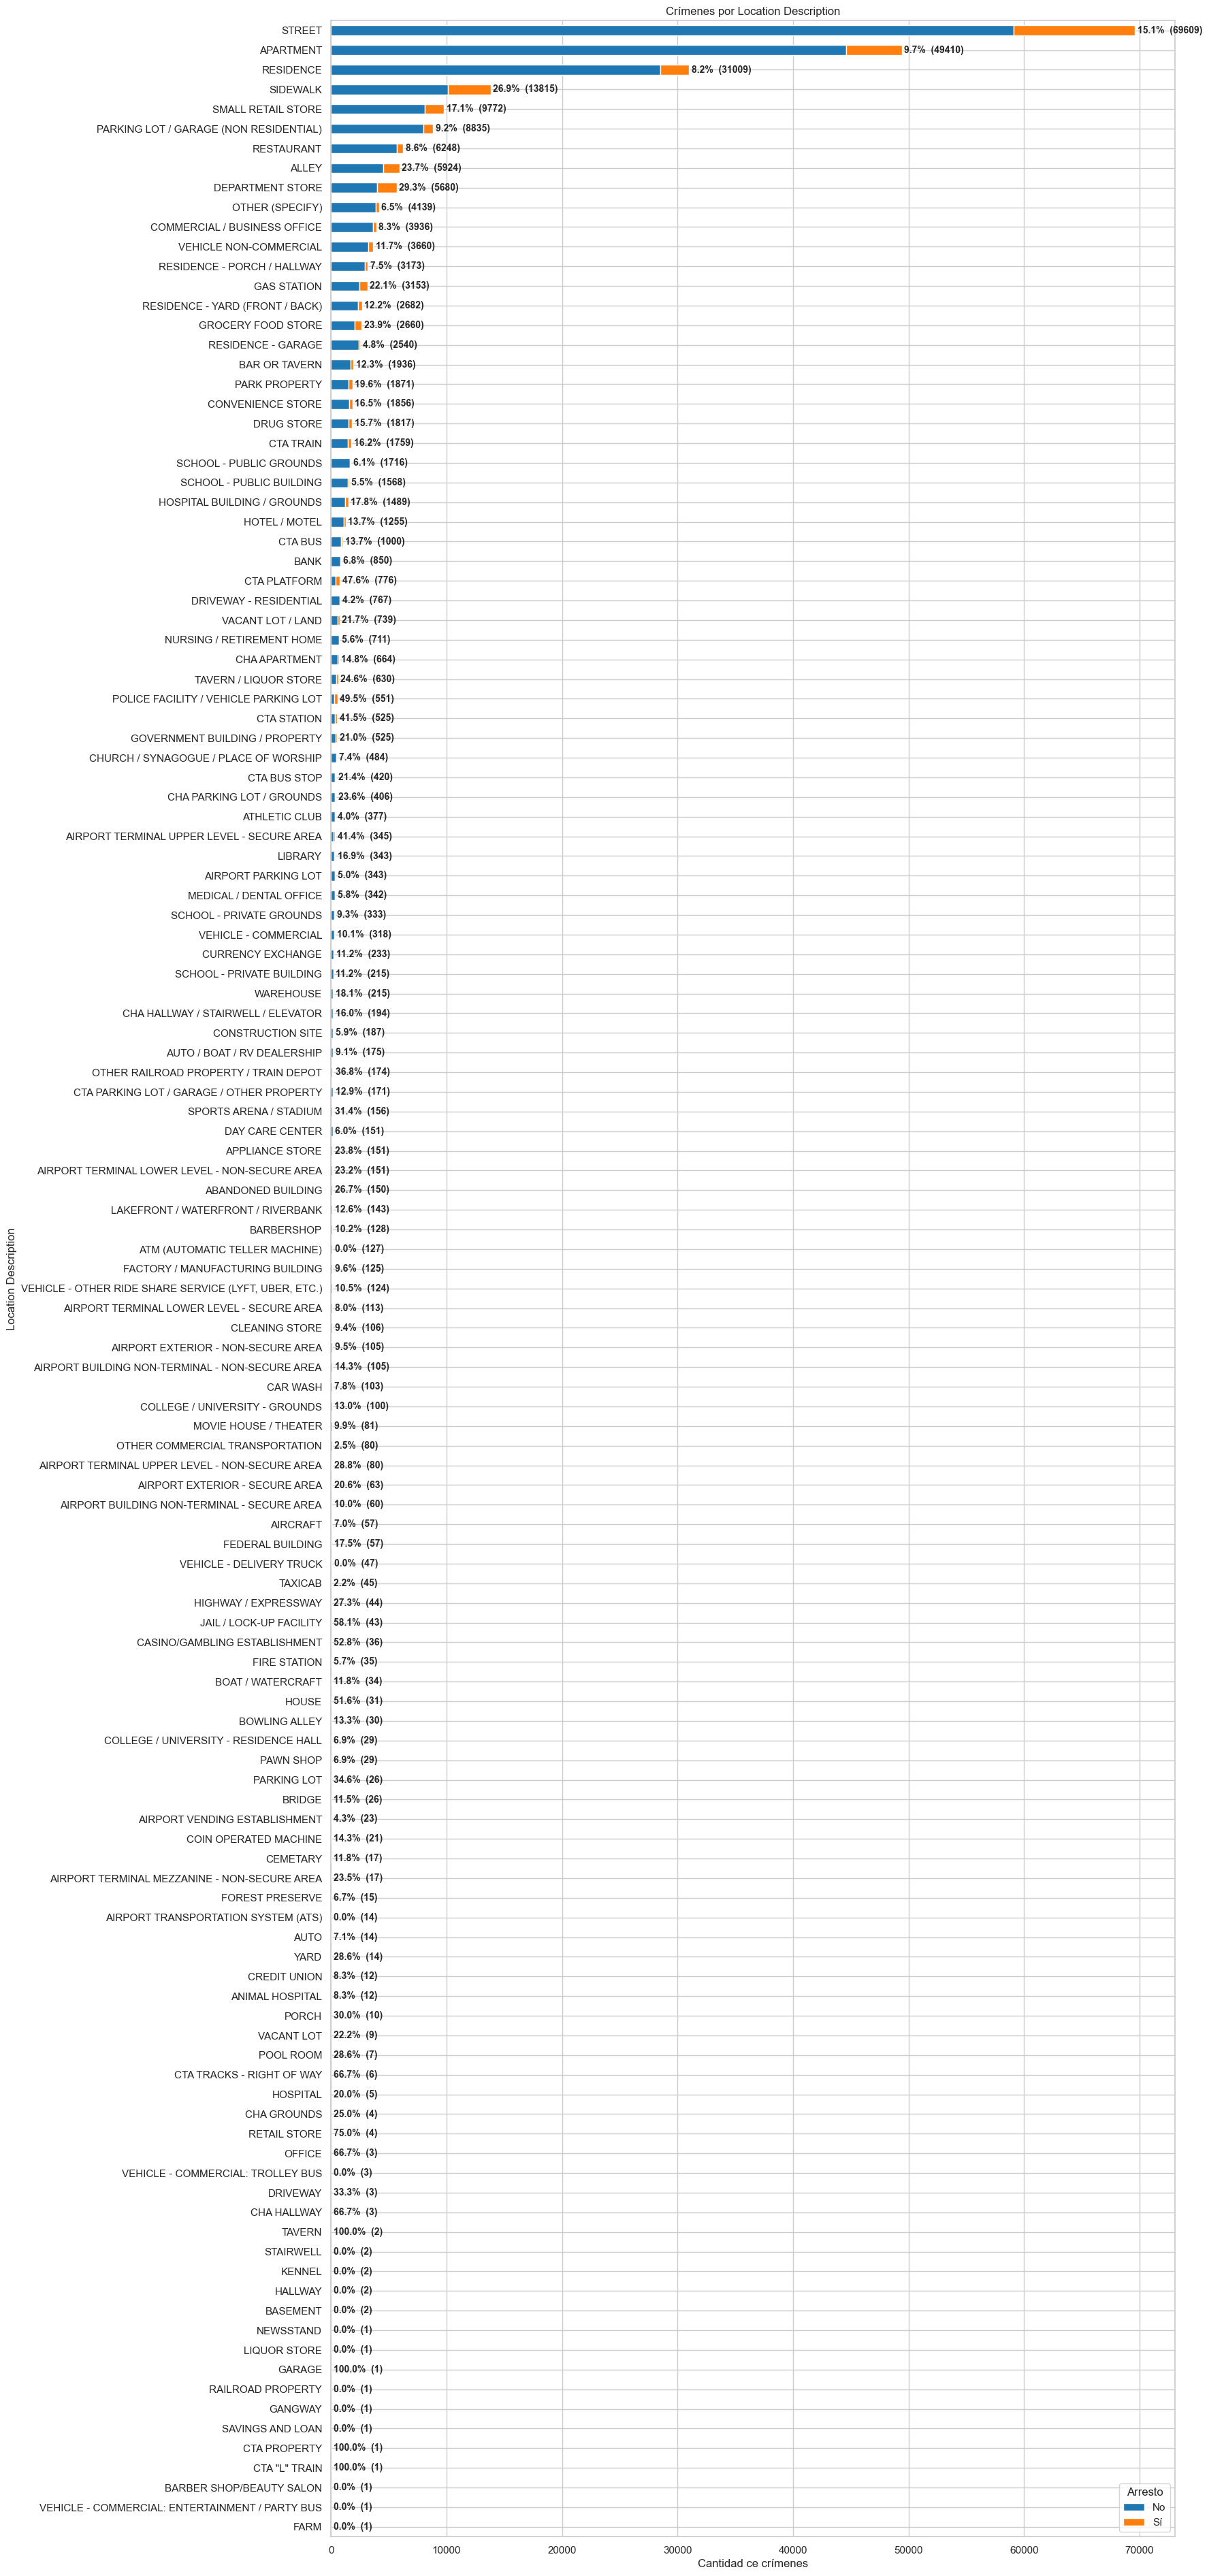

In [24]:
ld_arresto = df.groupby(['Location Description', 'Arrest']).size().unstack(fill_value=0)

ld_arresto['total'] = ld_arresto.sum(axis=1)
ld_arresto = ld_arresto.sort_values('total', ascending=True).drop(columns='total')

totales = ld_arresto[False]+ ld_arresto[True]
porcentajes = 100 * ld_arresto[True] / totales.replace(0, np.nan)

ax = ld_arresto.plot(
    kind='barh',
    stacked=True,
    figsize=(16, 48),
    color=['#1f77b4', '#ff7f0e']
)

for idx, pct in enumerate(porcentajes):
    if not np.isnan(pct):
        ax.text(
            totales.iloc[idx] + 200, idx,
            f'{pct:.1f}%  ({totales.iloc[idx]})',
            ha='left', va='center', fontsize=10, fontweight='bold'
        )

plt.title('Crímenes por Location Description')
plt.xlabel('Cantidad ce crímenes')
plt.ylabel('Location Description')
plt.legend(title='Arresto', labels=['No', 'Sí'])
plt.show()

### Visualización de situación legal de los crímenes

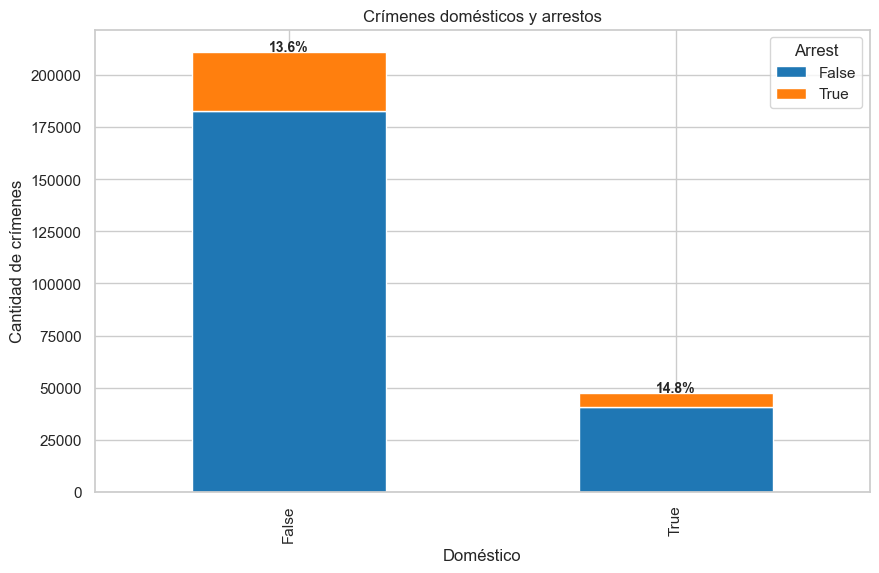

In [25]:
domestic_arrests = df.groupby(['Domestic', 'Arrest']).size().unstack(fill_value=0)

totales = domestic_arrests[False] + domestic_arrests[True]
porcentajes = 100 * domestic_arrests[True] / totales.replace(0, np.nan)

ax = domestic_arrests.plot(
    kind='bar',
    stacked=True,
    figsize=(10,6),
    color=['#1f77b4', '#ff7f0e']
)

for idx, pct in enumerate(porcentajes):
    if not np.isnan(pct):
        ax.text(
            idx, totales.iloc[idx] + 2000,
            f'{pct:.1f}%',
            ha='center', va='center', fontsize=10, fontweight='bold'
        )

plt.title('Crímenes domésticos y arrestos')
plt.xlabel('Doméstico')
plt.ylabel('Cantidad de crímenes')
plt.show()

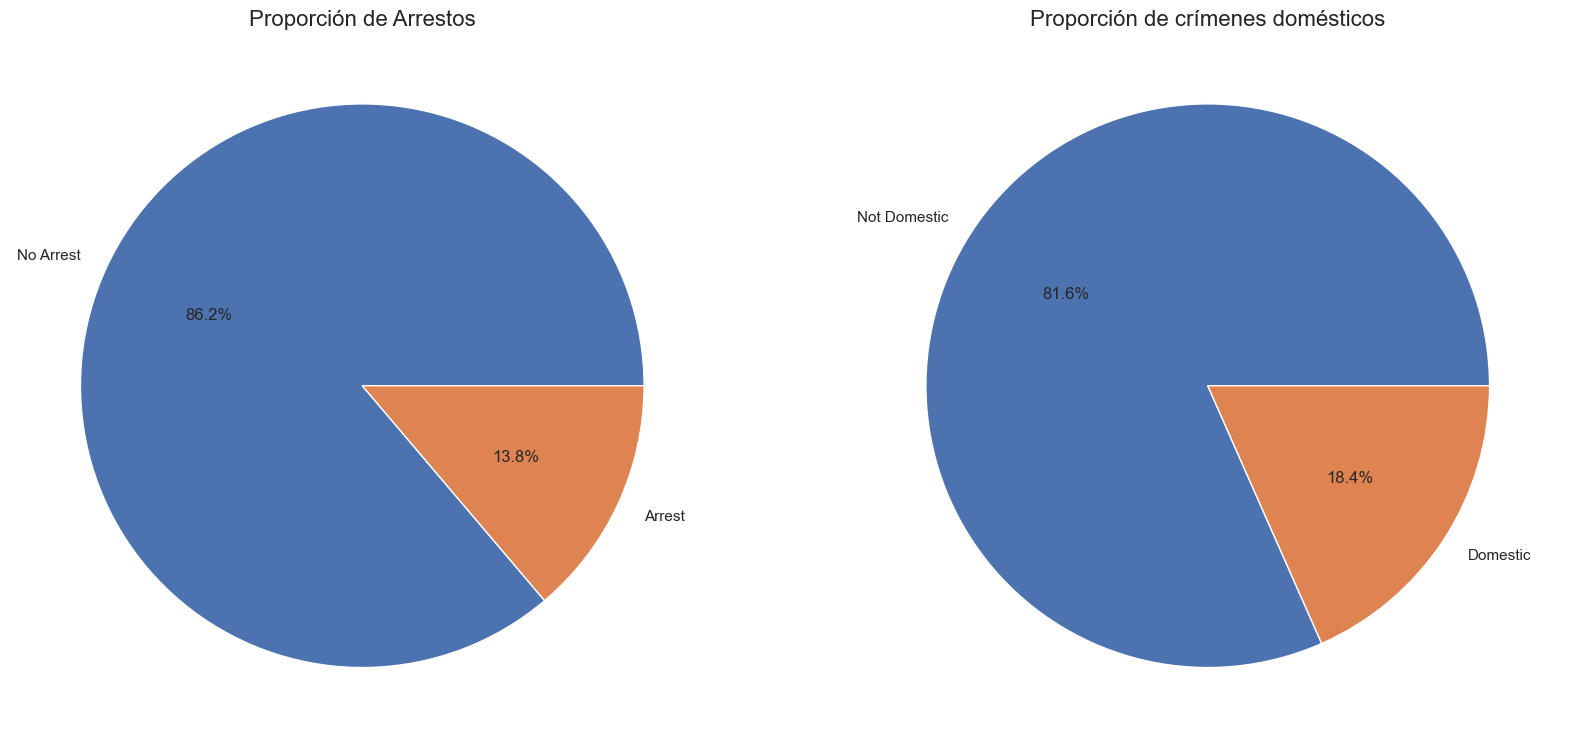

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].pie(df['Arrest'].value_counts(), labels=['No Arrest', 'Arrest'], autopct='%1.1f%%')
axs[0].set_title('Proporción de Arrestos', fontsize=16)

axs[1].pie(df['Domestic'].value_counts(), labels=['Not Domestic', 'Domestic'], autopct='%1.1f%%')
axs[1].set_title('Proporción de crímenes domésticos', fontsize=16)
plt.show()

A este punto se encuentra visualizada en gran parte la distribución de crímenes por cada una de las variables individuales. A partir de quí, el análisis debería empezar a combinar estas variables para definir una relación entre ellas.

### Relaciones entre variables de agrupaciones diferentes
Se grafican las relaciones cruzadas entre variables que distintas agrupaciones (Tiempo, Lugar, Clasificación, etc).

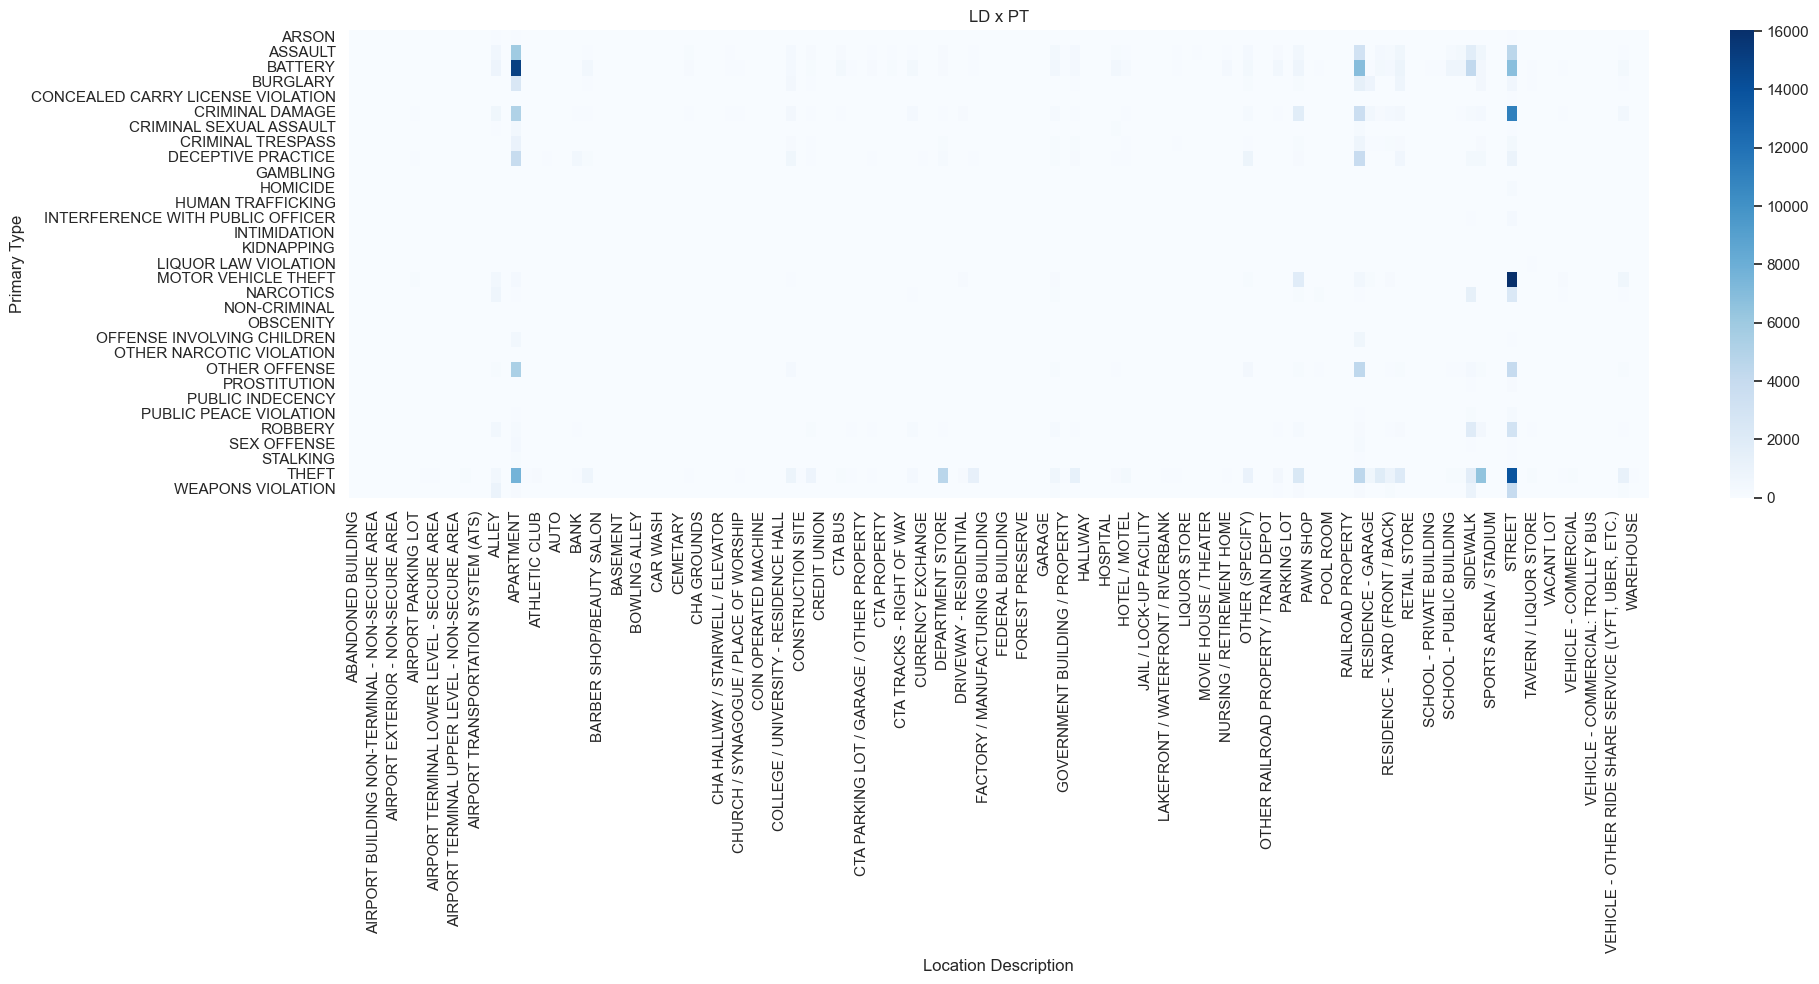

In [ ]:
cross_tab = pd.crosstab(df['Primary Type'], df['Location Description'])

plt.figure(figsize=(20, 10))
sns.heatmap(cross_tab, annot=False, fmt='d', cmap='Blues')
plt.title('Location Description x Primary Type')
plt.xlabel('Location Description')
plt.ylabel('Primary Type')
plt.tight_layout()
plt.show()

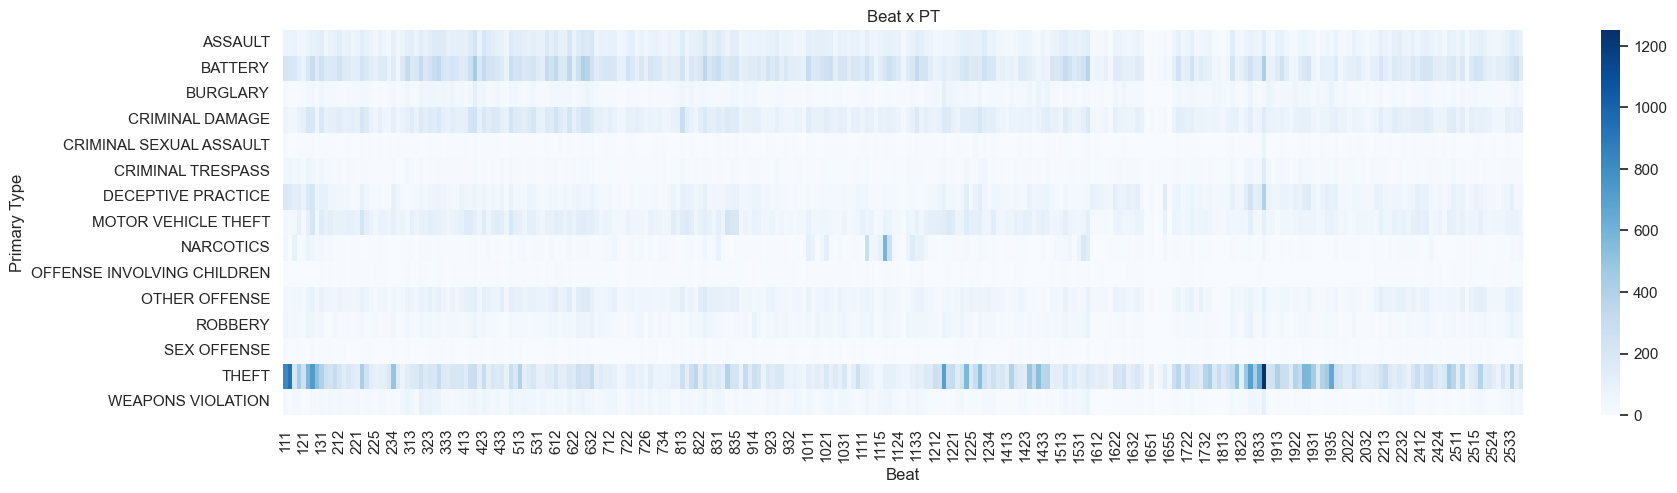

In [41]:
top10_pt = df['Primary Type'].value_counts().nlargest(15).index
df_top10_pt = df[df['Primary Type'].isin(top10_pt)]

cross_tab = pd.crosstab(df_top10_pt['Primary Type'], df_top10_pt['Beat'])

plt.figure(figsize=(20, 5))
sns.heatmap(cross_tab, annot=False, fmt='d', cmap='Blues')
plt.title('Beat vs Primary Type')
plt.xlabel('Beat')
plt.ylabel('Primary Type')
plt.show()

In [ ]:
cross_tab = pd.crosstab(df['Beat'], df['Location Description'])

plt.figure(figsize=(20, 20))
sns.heatmap(cross_tab, annot=False, fmt='d', cmap='Blues')
plt.title('Location Description vs Beat')
plt.xlabel('Location Description')
plt.ylabel('Beat')
plt.tight_layout()
plt.show()

En ambos mapas, se pueden notar algunas "franjas", tanto verticales como horizontales, lo que indica una distribución general en la cantidad de crímenes por Primary Type, Location y Beat. Sin emabrgo, se pueden notar alguas "islas" interesantes como es el cruce de Primary Type=Narcotics y Beat={1111,...,1124} (O visto de otra manera, District=11) que permiten suponer un tipo de crimen más específicamente relacionado a algunas zonas.

Para validar esto, analizamos la cantidad de crímenes de cada tipo para el distrito 11 y viceversa, cantidad de crímenes de tipo "Narcotics" para cada District (Podrían ser por Beats también).

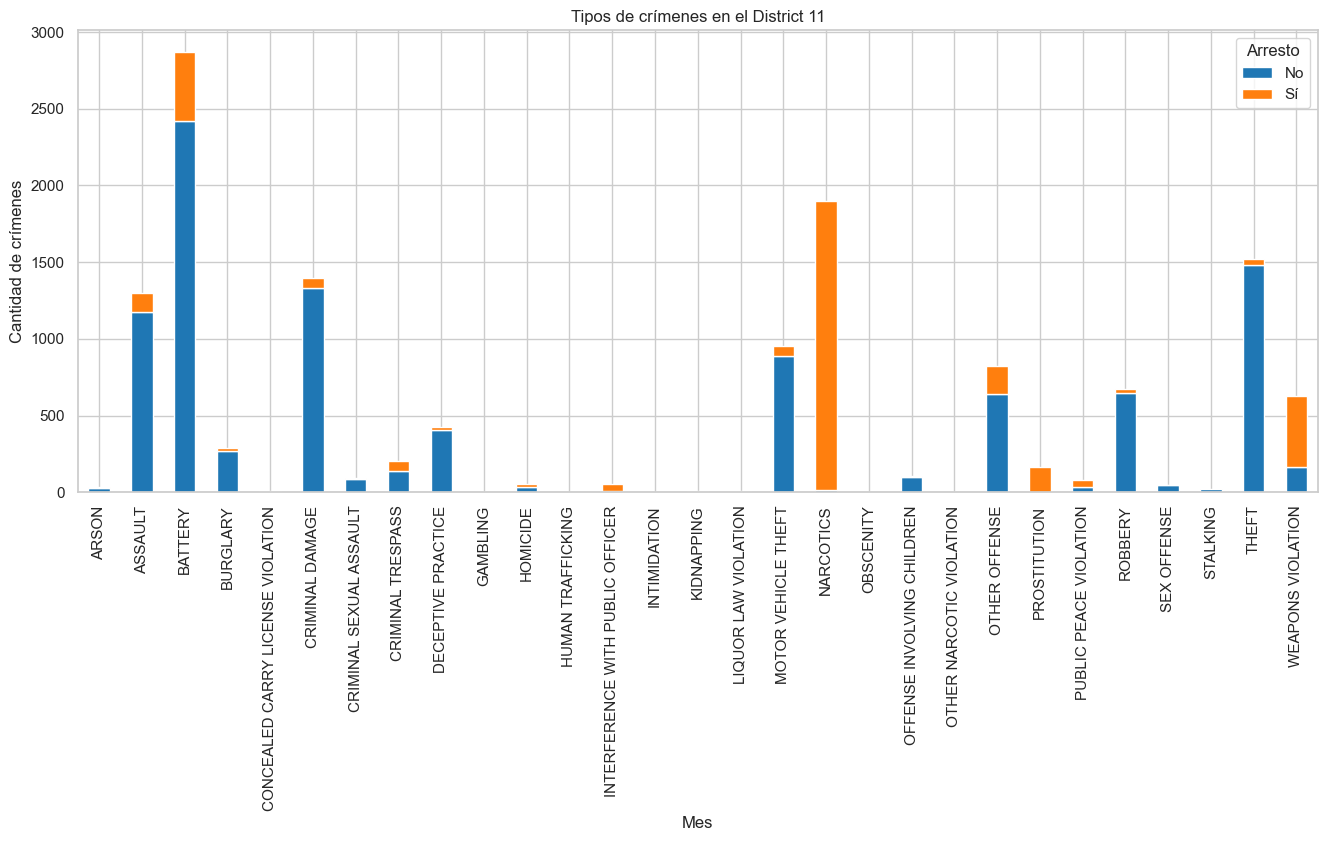

In [49]:
district11_crimes = df[df['District'] == 11]

pt_district11_crimes = district11_crimes.groupby(['Primary Type', 'Arrest']).size().unstack(fill_value=0)

ax = pt_district11_crimes.plot(
    kind='bar',
    stacked=True,
    figsize=(16, 6),
    color=['#1f77b4', '#ff7f0e']    
)

plt.title('Tipos de crímenes en el District 11')
plt.xlabel('Mes')
plt.ylabel('Cantidad de crímenes')
plt.legend(title='Arresto', labels=['No', 'Sí'])
plt.show()

Esto refuerza la suposición anterior, ya que se ve claramente que "Narcotics" es el segundo Primary Type más frecuente para este District, y en la distribución general de Primary Type para todos los crímenes ni siquiera entra en el Top 10.

También se puede ver que el tipo "Battery" prácticamente duplica al tipo "Theft" en este District, pero en el ranking general el tipo Theft era el más frecuente por una amplia diferencia.

Estos son hallazgos interesantes y, probablemente, aparezcan muchos otros similares continuando el análisis del dataset, lo que permitiría sacar nuevas conclusiones y plantear nuevos modelos de ML, pero para el análisis pretendido se estaría volviendo demasiado extenso. Además, no estarían aportando valor al problema a resolver ya definido (se define a continuación pero en realidad fue definido anteriormente).

## Definicion del problema de ML
Antes de seguir con el análisis del dataset, para que no se vuelva demasiado extenso, se propone el problema de Machine Learning tentativo a resolver:

A partir del dataset de entrenamiento, se busca crear un modelo de Machine Learning cuyo objetivo será predecir si un crimen terminará en arresto o no.
- Problema: Clasificación
- Target: Arresto